<a href="https://colab.research.google.com/github/aamirkhanov/mu2e_crv/blob/main/DeadTimeEstimatorMDC2020_thresholds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and cuts definition

In [1]:
!pip install -q hist
!pip install -q uproot
!pip install -q mplhep

!pip install -q uncertainties
!pip install -I -q git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts


import hist
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import uproot

fCEold='drive/MyDrive/root_files_cry5/nts.mu2e.CeEndpointMix2BBSignal.MDC2020w_perfect_v1_0.tka'

fCE='drive/MyDrive/root_files_cry5/nts.owner.trkana-reco-CEtest.version.sequencer2.root'
fCRY5lo='drive/MyDrive/root_files_cry5/nts.mu2e.CosmicCRYloOnSpillSignal.MDC2020w_perfect_v1_0.tka'
fCRY5hi='drive/MyDrive/root_files_cry5/nts.mu2e.CosmicCRYhiOnSpillSignal.MDC2020w_perfect_v1_0.tka'

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)

import mplhep as hep
hep.style.use('ATLAS')  # or ATLAS/LHCb2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.2/334.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.0/703.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


#Copy the data over

In [2]:
if False:
  !apt-get install krb5-user
  !wget https://authentication.fnal.gov/krb5conf/SL7/krb5.conf
  import os
  os.environ['KRB5_CONFIG'] = 'krb5.conf'
  !kinit oksuzian@FNAL.GOV
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.mu2e.CosmicCRYhiOnSpillSignal.MDC2020w_perfect_v1_0.tka drive/MyDrive/root_files_cry5/
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.mu2e.CosmicCRYloOnSpillSignal.MDC2020w_perfect_v1_0.tka drive/MyDrive/root_files_cry5/
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.mu2e.CeEndpointMix2BBSignal.MDC2020w_perfect_v1_0.tka drive/MyDrive/root_files_cry5/

#init

In [3]:
TMIN = -150
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 103.85
PMAX_PHY = 105.1

#Default MDC-style cut box
cuts = [
    "(dem_status > 0)",
    "(dement_td > 0.577350)",
    "(dement_td < 1.000)",
    "(dement_d0 > -80)",
    "(dement_d0 < 105)",
    "(dement_maxr > 450)",
    "(dement_maxr < 680)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    #"(demqual_TrkQual > 0.8)",
    "(demqual_TrkPID > 0.95)",
    "(uem_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(dement_mom > %f)" % PMIN_EXT,
    "(dement_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(dement_mom > %f)" % PMIN_PHY,
    "(dement_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(dement_td > 0.577350)",
    "(dement_td < 1.000)",
    "(dement_d0 > -80)",
    "(dement_d0 < 205)",
    "(dement_maxr > 450)"
]
cut_lbox = " & ".join(cuts)

cut_t0='(dem_t0 > 650) & (dem_t0 < 1625)'
#crv_live_window='((crvinfo_timeWindowStart > 475 & crvinfo_timeWindowStart < 1650) | crvinfo_timeWindowStart<1)'
crv_live_window='((crv8PEs_timeWindowStart > 475 & crv8PEs_timeWindowStart < 1650) | crv8PEs_timeWindowStart<1)'
# Outside of the coincidence time window
#crv_time = "(de_t0 < crvinfo_timeWindowStart + %d | de_t0 > crvinfo_timeWindowEnd + %d)" % (TMIN, TMAX)
crv_time = "(de_t0 < crv8PEs_timeWindowStart + %d | de_t0 > crv8PEs_timeWindowEnd + %d)" % (-TMAX, -TMIN)
#de_t0 + TMAX < timeWindowStart | de_t0 + TMIN > timeWindowEnd
#de_t0 < timeWindowStart - TMAX | de_t0 > timeWindowEnd - TMIN
# Outside of the coincidence angular window
#crv_angle = "(crvinfo_angle < %d | crvinfo_angle > %d)" % (-2.5, 2.5)
crv_angle = "(debestcrv_angle < %d | debestcrv_angle > %d)" % (-2.5, 2.5)


#crv_time = "(crvinfo_dTe < %d | crvinfo_dTe > %d)" % (TMIN, TMAX)
#crv_time = crv_time+"& ( crvinfo_dTe < %d | crvinfo_dTe > %d)" % (-100, 150)
#crv_time = crv_time+"& (de_t0 < crvinfo_timeWindowStart | de_t0> crvinfo_timeWindowEnd)"
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_t0
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom+" & "+cut_t0
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom+" & "+cut_t0
#cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue+" & "+cut_t0
cut_loose  = cut_lbox +" & "+cut_t0

cut_extmom_notiming = cut_extmom
#cut_extmom = cut_extmom+" & " + cut_t0+" & " + crv_live_window
#cut_current = cut_extmom+" & ("+crv_time+" | "+crv_angle+")"
cut_current = cut_extmom+" & "+crv_time

In [4]:
##crvSector_list=["NA", "Right", "Left", "Top", "CRV-E", "CRV-U", "CRV-D", "CRV-C1", "CRV-C2", "CRV-C3"]
crvSector_list=["NA", "Right", "Left", "Top", "E", "U", "D", "C1", "C2", "C3"]
time_values={
  'NA' : [0, 0],
  'Right' : [-150, 40],
  'Left' : [-130, 30],
  'Top' : [-170, 40],
  'E' : [-70, 0],
  'U' : [-90, 20],
  'D' : [-200, 40],
  'C1' : [-150, 50],
  'C2' : [-200, -50],
  'C3' : [-200, 30]
}
crv_time_ext = ""
PEs_thr = 8
for sec in range(1,len(crvSector_list)):
  cut_ = "(((de_t0 < crv%dPEs_timeWindowStart + %d) | (de_t0 > crv%dPEs_timeWindowEnd + %d)) & crv%dPEs_crvSectorType == %d)" % (PEs_thr, -time_values[crvSector_list[sec]][1], PEs_thr,  -time_values[crvSector_list[sec]][0], PEs_thr, sec)
  if(crvSector_list[sec] == "C3"):
    crv_time_ext = crv_time_ext + cut_
  else:
    crv_time_ext = crv_time_ext + cut_ + " | "

#crv_time_ext = crv_time_ext + " & abs(demcpri_pdg) == 13"
print(crv_time_ext)

(((de_t0 < crv8PEs_timeWindowStart + -40) | (de_t0 > crv8PEs_timeWindowEnd + 150)) & crv8PEs_crvSectorType == 1) | (((de_t0 < crv8PEs_timeWindowStart + -30) | (de_t0 > crv8PEs_timeWindowEnd + 130)) & crv8PEs_crvSectorType == 2) | (((de_t0 < crv8PEs_timeWindowStart + -40) | (de_t0 > crv8PEs_timeWindowEnd + 170)) & crv8PEs_crvSectorType == 3) | (((de_t0 < crv8PEs_timeWindowStart + 0) | (de_t0 > crv8PEs_timeWindowEnd + 70)) & crv8PEs_crvSectorType == 4) | (((de_t0 < crv8PEs_timeWindowStart + -20) | (de_t0 > crv8PEs_timeWindowEnd + 90)) & crv8PEs_crvSectorType == 5) | (((de_t0 < crv8PEs_timeWindowStart + -40) | (de_t0 > crv8PEs_timeWindowEnd + 200)) & crv8PEs_crvSectorType == 6) | (((de_t0 < crv8PEs_timeWindowStart + -50) | (de_t0 > crv8PEs_timeWindowEnd + 150)) & crv8PEs_crvSectorType == 7) | (((de_t0 < crv8PEs_timeWindowStart + 50) | (de_t0 > crv8PEs_timeWindowEnd + 200)) & crv8PEs_crvSectorType == 8) | (((de_t0 < crv8PEs_timeWindowStart + -30) | (de_t0 > crv8PEs_timeWindowEnd + 200)) & 

#Checking ROOT file directly

In [ ]:
from warnings import simplefilter
_trk = uproot.open(fCE+":TrkAnaNeg/trkana")

In [ ]:
tree = _trk['dembestcrv8PEs./dembestcrv8PEs._timeWindowStart']
_arr  = tree.arrays()
#branches['debestcrv8PEs._timeWindowStart']['debestcrv8PEs._timeWindowStart']
print(len(_arr[_arr['debestcrv8PEs._timeWindowStart'] > 0]))

tree = _trk['debestcrv20PEs./debestcrv20PEs._timeWindowStart']
_arr  = tree.arrays()
#branches['debestcrv8PEs._timeWindowStart']['debestcrv8PEs._timeWindowStart']
print(len(_arr[_arr['debestcrv20PEs._timeWindowStart'] > 0]))


In [ ]:
print(len(_trk[ 'debestcrv8PEs./debestcrv8PEs._timeWindowStart'].arrays()))
print(len(_trk[ 'debestcrv20PEs./debestcrv20PEs._timeWindowStart'].arrays()))

In [ ]:
_trk[ 'debestcrv8PEs./debestcrv8PEs._timeWindowStart'].arrays()

In [ ]:
_trk.keys()

#Load dataframe

In [5]:
def make_df(trkana, tag_high, mc=True):

  #df = trkana.arrays(filter_name=['evtinfo.*', 'evtinfomc.*', 'de.*', 'deent*', 'demc.*', 'demcgen.*', 'demcpri.*', 'ue.*', 'crvsummary.*', 'crvsummarymc.*', 'dequal*', 'detrkpid*', 'debestcrv*', 'debestcrvmc./*'],library="pd")
  df = trkana.arrays(filter_name=['evtinfo.*', 'evtinfomc.*', 'de.*', 'deent*', 'demc.*', 'demcgen.*', 'demcpri.*', 'ue.*', 'crvsummary.*', 'crvsummarymc.*', 'dequal*', 'detrkpid*', 'debestcrv*', 'debestcrvmc./*',
                                  'evtinfo.*', 'evtinfomc.*', 'dem.*', 'dement*', 'demmc.*', 'demmcgen.*', 'demmcpri.*', 'uem.*', 'crvsummary.*', 'crvsummarymc.*', 'demqual*', 'demtrkpid*', 'dembestcrv*', 'dembestcrvmc*./*'],library="pd")
  df.columns = df.columns.str.replace('_fCoordinates_f', '')
  df.columns = df.columns.str.replace('.', '_')
  df.columns = df.columns.str.replace('__', '_')
  df.columns = df.columns.str.replace('_fCoordinates_f', '')
  df.columns = df.columns.str.replace('debest', '')
  df["dement_mom"] = pow(pow(df["dement_momX"],2) + pow(df["dement_momY"],2) + pow(df["dement_momZ"],2),0.5)
  if mc:
    df["demmcpri_mom"] = pow(pow(df["demmcpri_momX"],2) + pow(df["demmcpri_momY"],2) + pow(df["demmcpri_momZ"],2),0.5)

  #df['is_high'] = tag_high
  #df["crv_dT"] = df["crv8PEs_timeWindowStart"] - df["de_t0"]
  df = df.fillna(-999999)
  return df

In [6]:
utils.LIVETIME_LO_CRY5 = 99.4E6
utils.LIVETIME_HI_CRY5 = 2.56E6

In [ ]:
if False:
  trkana = uproot.open(fCRY5hi+":TrkAnaNeg/trkana")
  dfCRY5=make_df(trkana, 1)
  trkana = uproot.open(fCRY5lo+":TrkAnaNeg/trkana")
  dfCRY5 = dfCRY5.append(make_df(trkana, 0))
  trkana = uproot.open(fCE+":TrkAnaNeg/trkana")
  dfCE=make_df(trkana, -1, False)

In [6]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
#trkana = uproot.open(fCEold+":TrkAnaNeg/trkana")
#dfCEold=make_df(trkana, -1, False)
trkana = uproot.open(fCE+":TrkAnaNeg/trkana")
dfCE=make_df(trkana, -1, False)

<ipython-input-5-3fa16402a265>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', '_')


In [ ]:
list(dfCE)

#Compare old and new DF variables

Text(1, 0, 'Total PE, PEs')

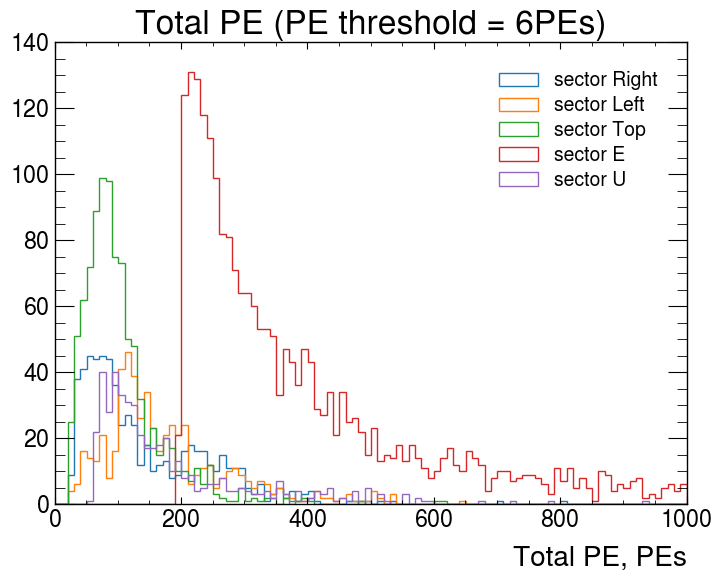

In [89]:
#crvSector_list=["NA", "Right", "Left", "Top", "E", "U", "D", "C1", "C2", "C3"]

for sec in range(1,6):
  plt.hist(dfCE.query("dembestcrv6PEs_crvSectorType == %d" % sec)["dembestcrv6PEs_PEs"], range=(1,1000), bins=100, histtype='step', label="sector %s"%crvSector_list[sec]);
plt.legend()
plt.title("Total PE (PE threshold = 6PEs)")
plt.xlabel('Total PE, PEs')

Text(1, 0, 'Total PE, PEs')

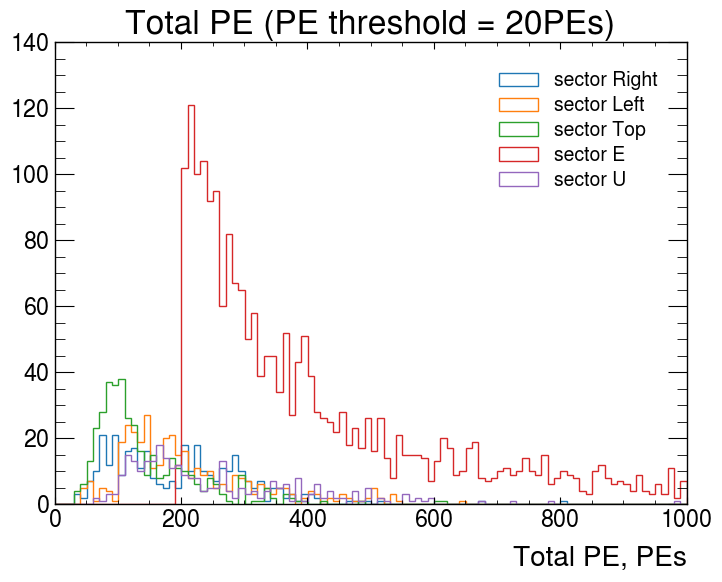

In [94]:
for sec in range(1,6):
  plt.hist(dfCE.query("dembestcrv20PEs_crvSectorType == %d" % sec)["dembestcrv20PEs_PEs"], range=(1,1000), bins=100, histtype='step', label="sector %s"%crvSector_list[sec]);
plt.legend()
plt.title("Total PE (PE threshold = 20PEs)")
plt.xlabel('Total PE, PEs')

In [ ]:
plt.hist(dfCEold["de_t0"])

#Dead time by sector

In [ ]:
cut_current

'dembestcrv20PEs_crvSectorType == 9 & ((dem_t0 > dembestcrv20PEs_timeWindowStart + -150) & (dem_t0 < dembestcrv20PEs_timeWindowEnd + 50))'

In [39]:
for total_PEs in [0] + list(range(PEs_min,PEs_max,50)):
  print(total_PEs)

0
180
230
280
330
380


In [81]:
#PEs_thr = 6

dead_time_sec=[[0, 'NA']]
dead_time_sec_ext=[[0, 'NA']]

total_PEs_values = [0] + list(range(150,500,50))
for total_PEs in total_PEs_values:

  for PEs_thr in range(6,21,2):

    for sec in range(1,len(crvSector_list)):

      if sec != 4 and total_PEs != 0:
        continue

      if sec == 4: #sector E
        cut_PEs = "& dembestcrv%dPEs_PEs > %d" % (PEs_thr,total_PEs)
      else:
        cut_PEs = ""


      #crv_time_sec = "((dem_t0 < dembestcrv%dPEs_timeWindowStart + %d) | (dem_t0 > dembestcrv%dPEs_timeWindowEnd + %d))" % (PEs_thr, -time_values[crvSector_list[sec]][1], PEs_thr,  -time_values[crvSector_list[sec]][0])
      #crv_time_sec = "((dem_t0 < dembestcrv%dPEs_timeWindowStart + %d) | (dem_t0 > dembestcrv%dPEs_timeWindowEnd + %d))" % (PEs_thr, time_values[crvSector_list[sec]][0], PEs_thr,  time_values[crvSector_list[sec]][1])
      cut1 = "dembestcrv%dPEs_crvSectorType == %d" % (PEs_thr, sec) + cut_PEs
      cut2 = "((dem_t0 > dembestcrv%dPEs_timeWindowStart + %d) & (dem_t0 < dembestcrv%dPEs_timeWindowEnd + %d))" % (PEs_thr, time_values[crvSector_list[sec]][0], PEs_thr,  time_values[crvSector_list[sec]][1])
      cut3 = "((dem_t0 > dembestcrv%dPEs_timeWindowStart + %d) & (dem_t0 < dembestcrv%dPEs_timeWindowEnd + %d))" % (PEs_thr, -150, PEs_thr, 50)

      #cut2 = "((dem_t0 > dembestcrv%dPEs_timeWindowStart + %d) & (dem_t0 < dembestcrv%dPEs_timeWindowStart + %d))" % (PEs_thr, time_values[crvSector_list[sec]][0], PEs_thr,  time_values[crvSector_list[sec]][1])
      #cut3 = "((dem_t0 > dembestcrv%dPEs_timeWindowStart + %d) & (dem_t0 < dembestcrv%dPEs_timeWindowStart + %d))" % (PEs_thr, -150, PEs_thr, 50)

      #cut_current_ext = cut_extmom+" & "+ cut1 +" & "+ cut2
      #cut_current = cut_extmom+" & "+ cut1 +" & "+ cut3

      #for total_PEs in range (180,400,50):
      #if sec == 4: #sector E
      #  cut_extmom = cut_extmom + "& dembestcrv%dPEs_PEs > %d" % (PEs_thr,total_PEs)

      cut_current_ext = cut1 +" & "+ cut2 +" & "+ cut_extmom
      cut_current = cut1 +" & "+ cut3 +" & "+ cut_extmom


      #cut_current = cut_extmom+" & "+crv_time

      h = hist.Hist(
        hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
        hist.axis.Regular(50, 400, 1700, name="x", label="t0 [ns]"),
        hist.storage.Weight(),
      )


      h.fill(cat="all", x=dfCE.query(cut_extmom)['dem_t0'].to_numpy())
      h.fill(cat="cut", x=dfCE.query(cut_current)['dem_t0'].to_numpy());

      dead_time_sec_ = 0
      dead_time_sec_ext_ = 0
      ## Check how the errors are calculated!
      dead_time_sec_err_ = 0
      dead_time_sec_ext_err_ = 0

      if(len(dfCE.query(cut_extmom)) != 0):
        ev_all_ = len(dfCE.query(cut_current))
        ev_extmom_ = len(dfCE.query(cut_extmom))
        ev_crv_ = len(dfCE.query(cut_current_ext))

        dead_time_sec_ = ev_all_ / ev_extmom_
        dead_time_sec_ext_ = ev_crv_ / ev_extmom_

        dead_time_sec_err_ = np.sqrt(ev_all_) / ev_extmom_
        dead_time_sec_ext_err_ = np.sqrt(ev_crv_) / ev_extmom_

      dead_time_sec.append([sec, crvSector_list[sec], PEs_thr, dead_time_sec_, dead_time_sec_err_, 'DEF', TMIN, TMAX, int(total_PEs)])
      dead_time_sec.append([sec, crvSector_list[sec], PEs_thr, dead_time_sec_ext_, dead_time_sec_ext_err_, 'EXT', time_values[crvSector_list[sec]][0], time_values[crvSector_list[sec]][1], int(total_PEs)])


      print(str(dead_time_sec_) + "; SECTOR= " + crvSector_list[sec] + "; " + cut_current + "\n")
  '''
      fig = plt.figure()
      #plt.title(crvSector_list[sec])

      h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut, %s" % crvSector_list[sec], rp_denom_label="Before CRV cut, %s" % crvSector_list[sec], rp_ylim=[0.0, 0.2], rp_uncert_draw_type='line');
      fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
      fig.get_axes()[1].set_ylabel('CE eff.')
      fig.get_axes()[1].set_xlim(400,1750)
  '''


0.020650263620386643; SECTOR= Right; dembestcrv6PEs_crvSectorType == 1 & ((dem_t0 > dembestcrv6PEs_timeWindowStart + -150) & (dem_t0 < dembestcrv6PEs_timeWindowEnd + 50)) & (dem_status > 0) & (dement_td > 0.577350) & (dement_td < 1.000) & (dement_d0 > -80) & (dement_d0 < 105) & (dement_maxr > 450) & (dement_maxr < 680) & (demqual_TrkPID > 0.95) & (uem_status <= 0) & (dement_mom > 90.000000) & (dement_mom < 140.000000) & (dem_t0 > 650) & (dem_t0 < 1625)

0.013913298183948448; SECTOR= Left; dembestcrv6PEs_crvSectorType == 2 & ((dem_t0 > dembestcrv6PEs_timeWindowStart + -150) & (dem_t0 < dembestcrv6PEs_timeWindowEnd + 50)) & (dem_status > 0) & (dement_td > 0.577350) & (dement_td < 1.000) & (dement_d0 > -80) & (dement_d0 < 105) & (dement_maxr > 450) & (dement_maxr < 680) & (demqual_TrkPID > 0.95) & (uem_status <= 0) & (dement_mom > 90.000000) & (dement_mom < 140.000000) & (dem_t0 > 650) & (dem_t0 < 1625)

0.0320738137082601; SECTOR= Top; dembestcrv6PEs_crvSectorType == 3 & ((dem_t0 > dembe

In [82]:
dfDeadTime = pd.DataFrame(dead_time_sec, columns=['Sector Number', 'Sector Name', 'PEs thr', 'Dead Time', "Error", "Time cut type", "TMIN", "TMAX", "total_PEs_min"])


In [83]:
pd.set_option('display.max_rows', None)
dfDeadTime

Sector Number Sector Name  PEs thr  Dead Time     Error Time cut type  \
0                0          NA      NaN        NaN       NaN          None   
1                1       Right      6.0   0.020650  0.001739           DEF   
2                1       Right      6.0   0.020064  0.001714           EXT   
3                2        Left      6.0   0.013913  0.001427           DEF   
4                2        Left      6.0   0.012595  0.001358           EXT   
5                3         Top      6.0   0.032074  0.002167           DEF   
6                3         Top      6.0   0.032220  0.002172           EXT   
7                4           E      6.0   0.117750  0.004153           DEF   
8                4           E      6.0   0.096954  0.003768           EXT   
9                5           U      6.0   0.017575  0.001604           DEF   
10               5           U      6.0   0.013035  0.001382           EXT   
11               6           D      6.0   0.000000  0.000000           DEF   
12               6           D      6.0   0.000000  0.000000           EXT   
13               7          C1      6.0   0.000000  0.000000           DEF   
14               7          C1      6.0   0.000000  0.000000           EXT   
15               8          C2      6.0   0.000000  0.000000           DEF   
16               8          C2      6.0   0.000000  0.000000           EXT   
17               9          C3      6.0   0.000000  0.000000           DEF   
18               9          C3      6.0   0.000000  0.000000           EXT   
19               1       Right      8.0   0.019039  0.001670           DEF   
20               1       Right      8.0   0.018453  0.001644           EXT   
21               2        Left      8.0   0.012595  0.001358           DEF   
22               2        Left      8.0   0.011277  0.001285           EXT   
23               3         Top      8.0   0.026362  0.001965           DEF   
24               3         Top      8.0   0.026362  0.001965           EXT   
25               4           E      8.0   0.119361  0.004181           DEF   
26               4           E      8.0   0.099151  0.003811           EXT   
27               5           U      8.0   0.016842  0.001571           DEF   
28               5           U      8.0   0.012888  0.001374           EXT   
29               6           D      8.0   0.000000  0.000000           DEF   
30               6           D      8.0   0.000000  0.000000           EXT   
31               7          C1      8.0   0.000000  0.000000           DEF   
32               7          C1      8.0   0.000000  0.000000           EXT   
33               8          C2      8.0   0.000000  0.000000           DEF   
34               8          C2      8.0   0.000000  0.000000           EXT   
35               9          C3      8.0   0.000000  0.000000           DEF   
36               9          C3      8.0   0.000000  0.000000           EXT   
37               1       Right     10.0   0.016257  0.001543           DEF   
38               1       Right     10.0   0.015671  0.001515           EXT   
39               2        Left     10.0   0.010545  0.001243           DEF   
40               2        Left     10.0   0.009080  0.001153           EXT   
41               3         Top     10.0   0.021383  0.001770           DEF   
42               3         Top     10.0   0.021236  0.001764           EXT   
43               4           E     10.0   0.119069  0.004176           DEF   
44               4           E     10.0   0.098858  0.003805           EXT   
45               5           U     10.0   0.015964  0.001529           DEF   
46               5           U     10.0   0.012302  0.001342           EXT   
47               6           D     10.0   0.000000  0.000000           DEF   
48               6           D     10.0   0.000146  0.000146           EXT   
49               7          C1     10.0   0.000000  0.000000           DEF   
50               7         

In [84]:
dfDeadTime.query('`Time cut type` == "DEF" & `Sector Name` == "E" & `total_PEs_min` == 200')

Sector Number Sector Name  PEs thr  Dead Time     Error Time cut type  \
161              4           E      6.0   0.117165  0.004142           DEF   
163              4           E      8.0   0.118776  0.004171           DEF   
165              4           E     10.0   0.118483  0.004166           DEF   
167              4           E     12.0   0.119069  0.004176           DEF   
169              4           E     14.0   0.116725  0.004135           DEF   
171              4           E     16.0   0.116432  0.004129           DEF   
173              4           E     18.0   0.116872  0.004137           DEF   
175              4           E     20.0   0.118483  0.004166           DEF   

      TMIN  TMAX  total_PEs_min  
161 -150.0  50.0          200.0  
163 -150.0  50.0          200.0  
165 -150.0  50.0          200.0  
167 -150.0  50.0          200.0  
169 -150.0  50.0          200.0  
171 -150.0  50.0          200.0  
173 -150.0  50.0          200.0  
175 -150.0  50.0          200.0

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/pytho

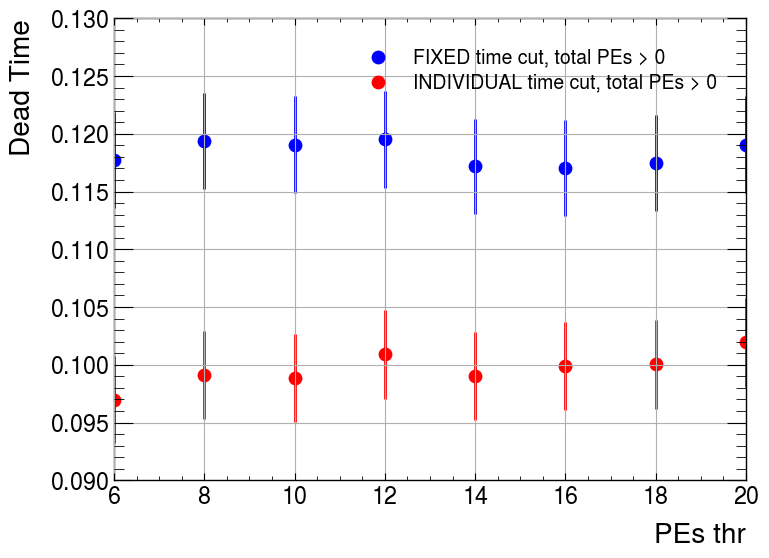

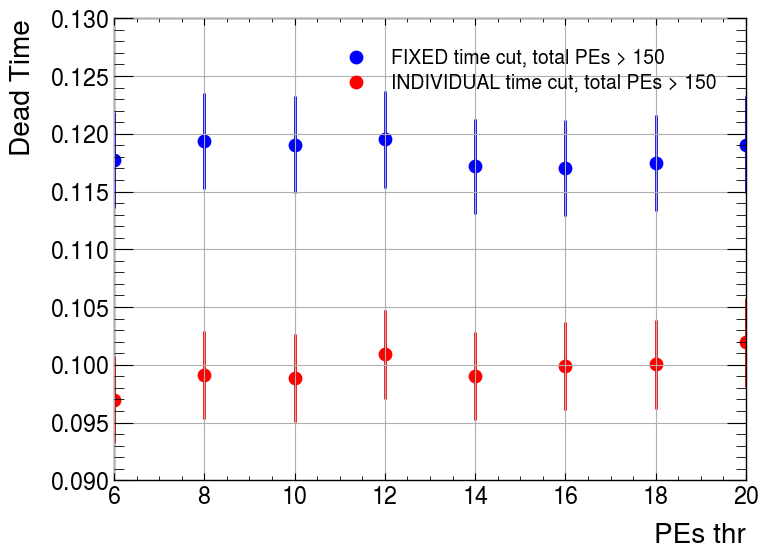

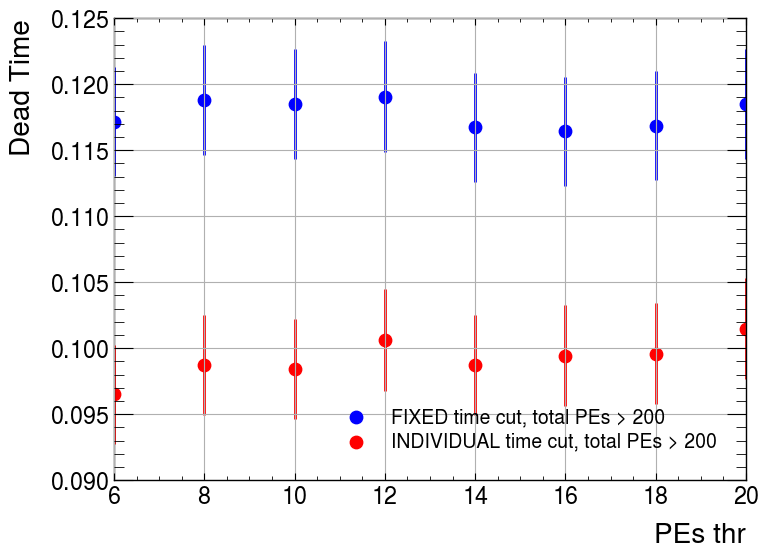

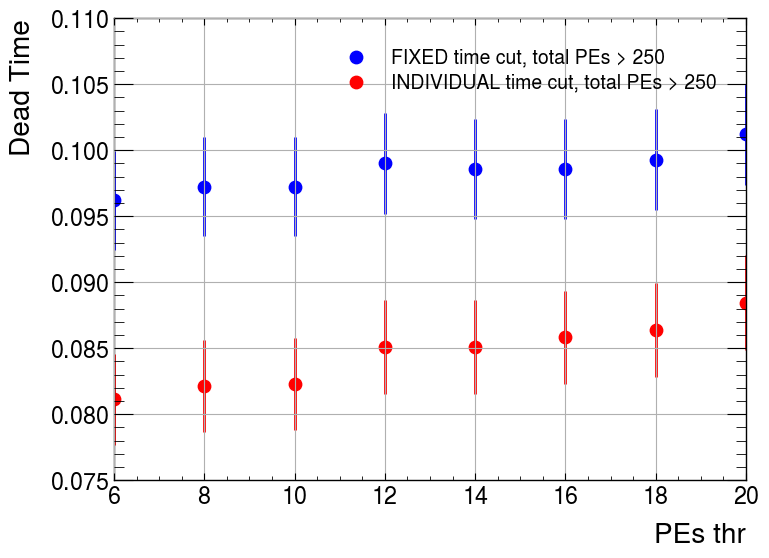

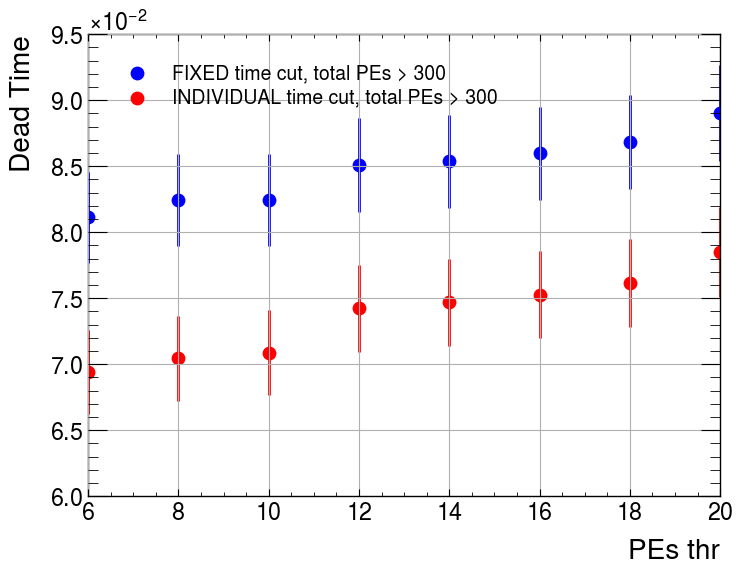

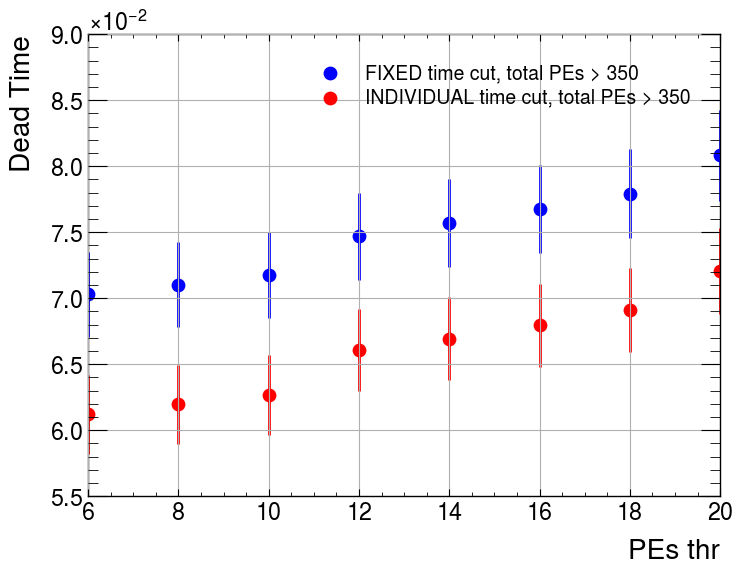

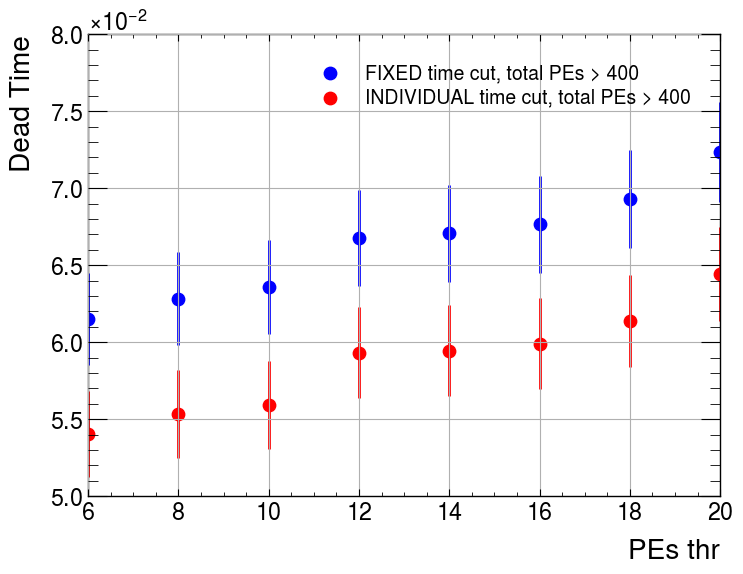

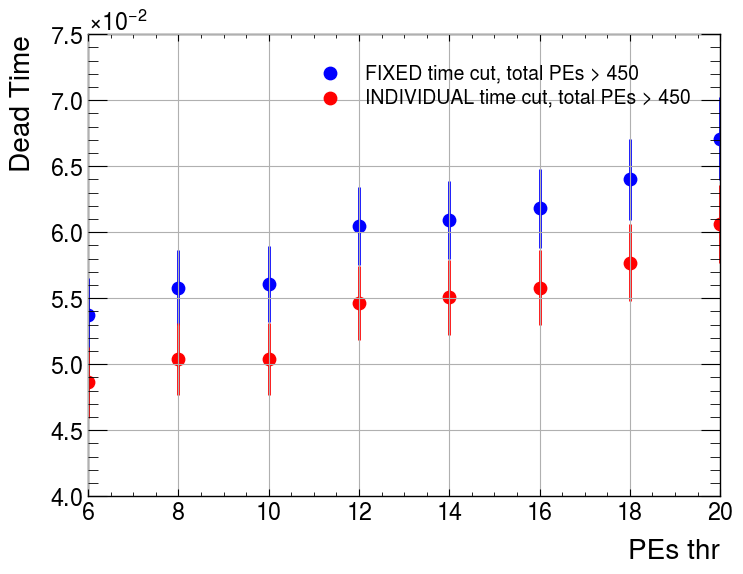

In [85]:
for PEs in total_PEs_values:
  ax = dfDeadTime.query('`Time cut type` == "DEF" & `Sector Name` == "E" & `total_PEs_min` == %f'%PEs).plot.scatter(x="PEs thr", y="Dead Time", yerr="Error", c='b', label="FIXED time cut, total PEs > %d"%PEs, s=80, grid='true');
  dfDeadTime.query('`Time cut type` == "EXT" & `Sector Name` == "E" & `total_PEs_min` == %f'%PEs).plot.scatter(x="PEs thr", y="Dead Time", yerr="Error", c='r', label="INDIVIDUAL time cut, total PEs > %d"%PEs, s=80, grid='true', ax=ax);
  ax.set_xlabel("PE threshold, PEs")
  ax.set_ylabel("Dead Time")


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 1.0, 'Dead time (PE threshold = 20PEs)')

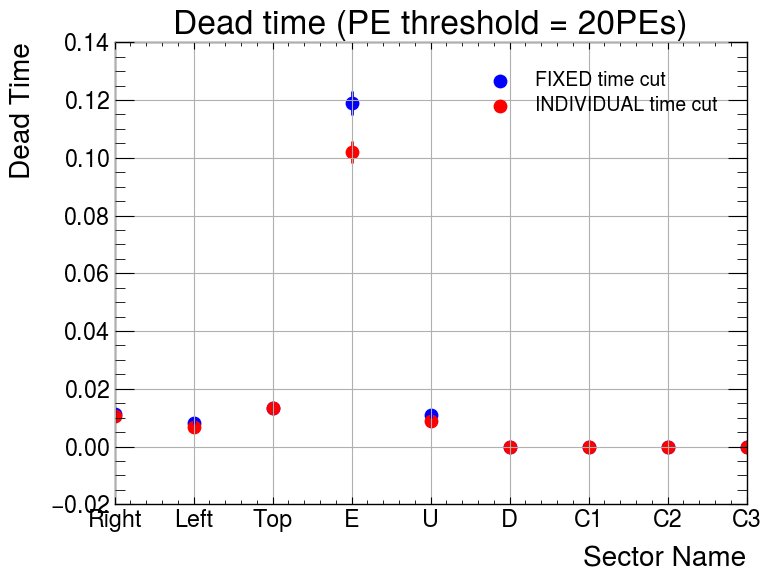

In [93]:
ax = dfDeadTime.query('`Time cut type` == "DEF" & `PEs thr` == 20 & `total_PEs_min` == 0').plot.scatter(x="Sector Name", y="Dead Time", yerr="Error", c='b', label="FIXED time cut", s=80, grid='true')
dfDeadTime.query('`Time cut type` == "EXT" & `PEs thr` == 20 & `total_PEs_min` == 0').plot.scatter(x="Sector Name", y="Dead Time", yerr="Error", c='r', label="INDIVIDUAL time cut", s=80, grid='true', ax=ax)
plt.title("Dead time (PE threshold = 20PEs)")


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/usr/local/lib/pytho

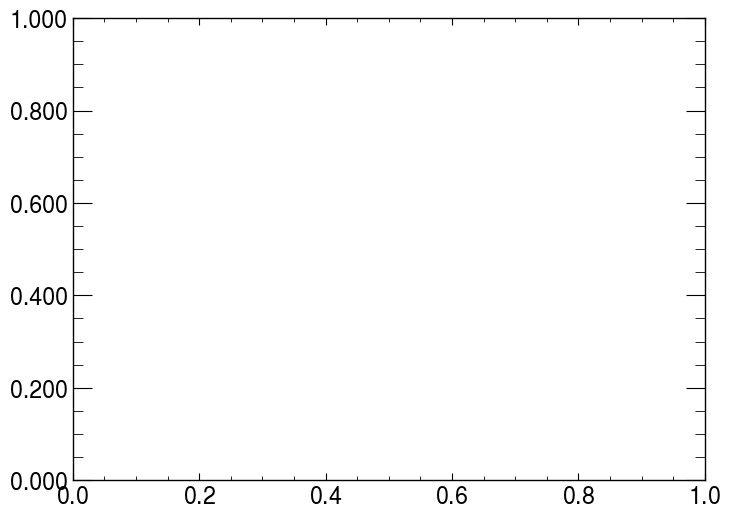

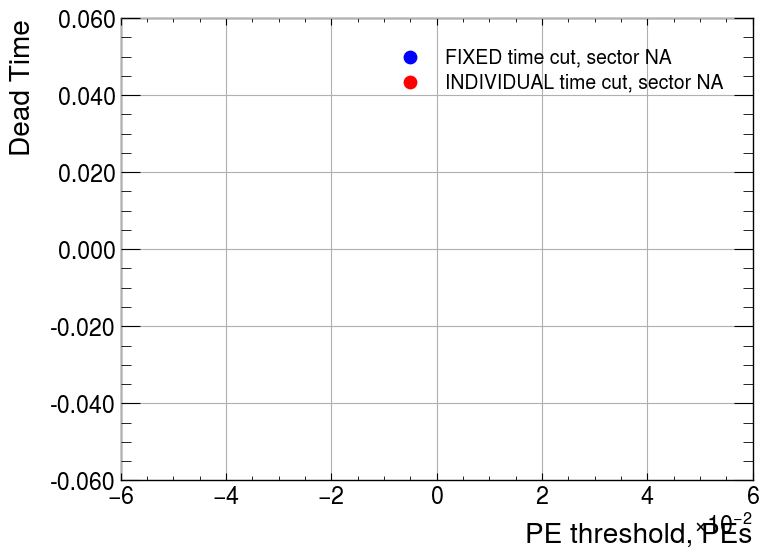

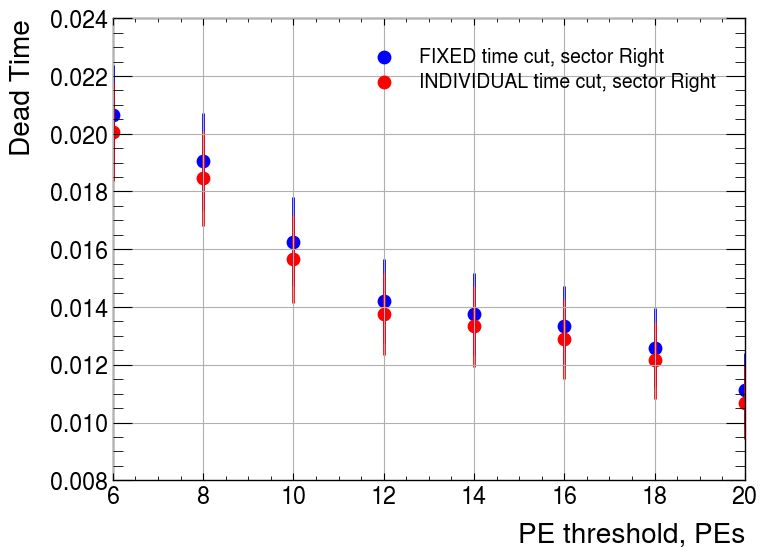

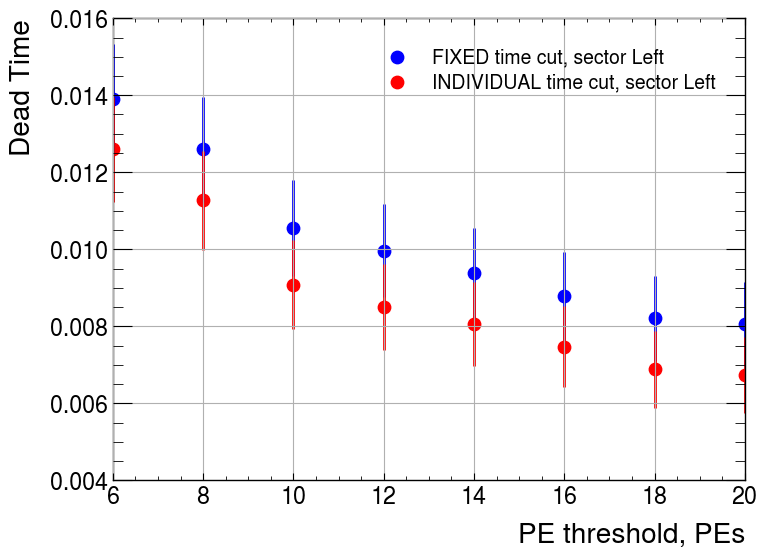

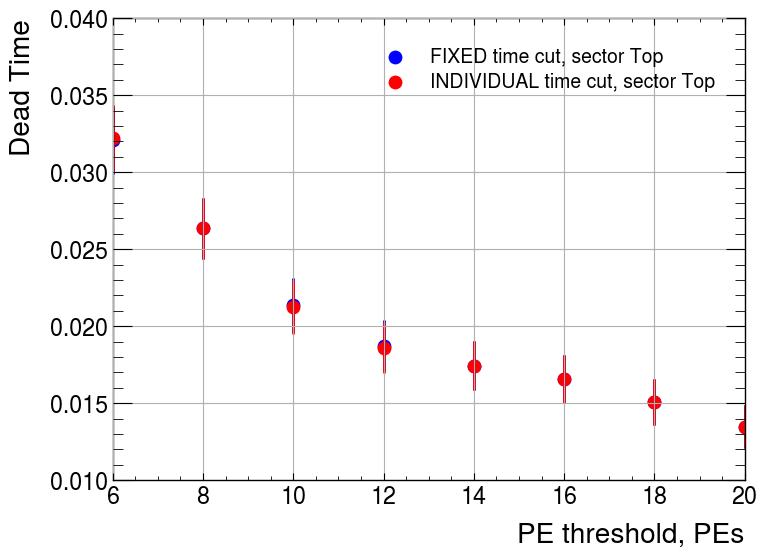

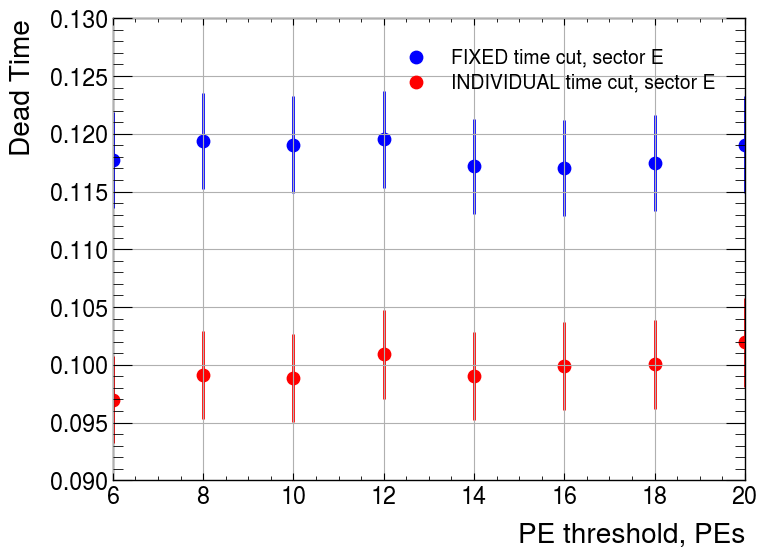

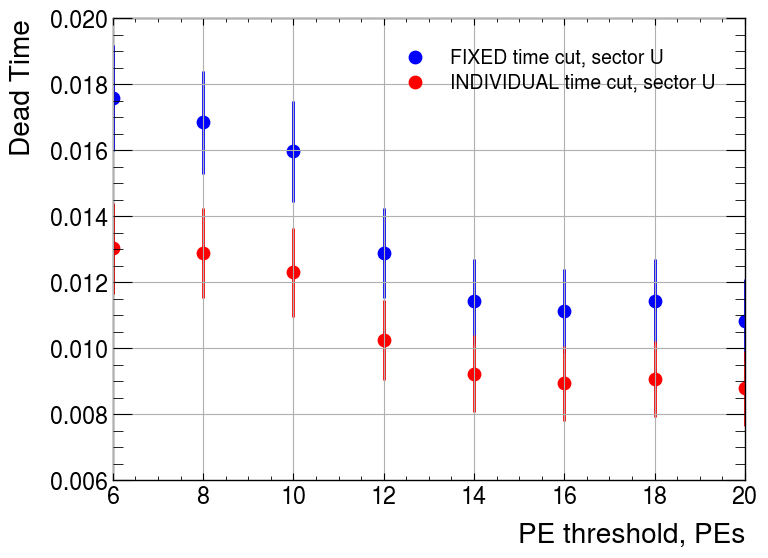

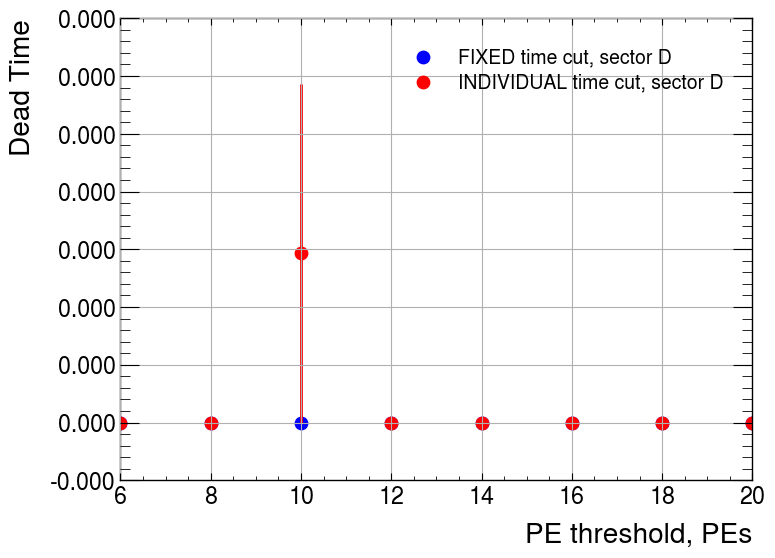

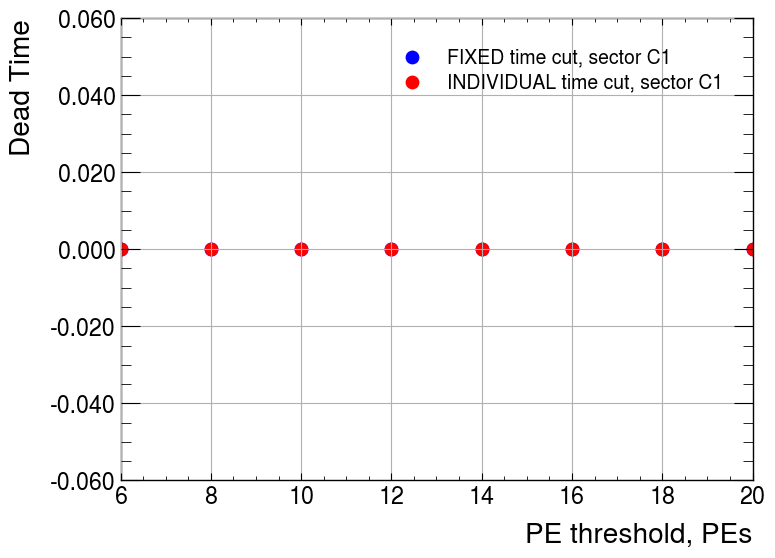

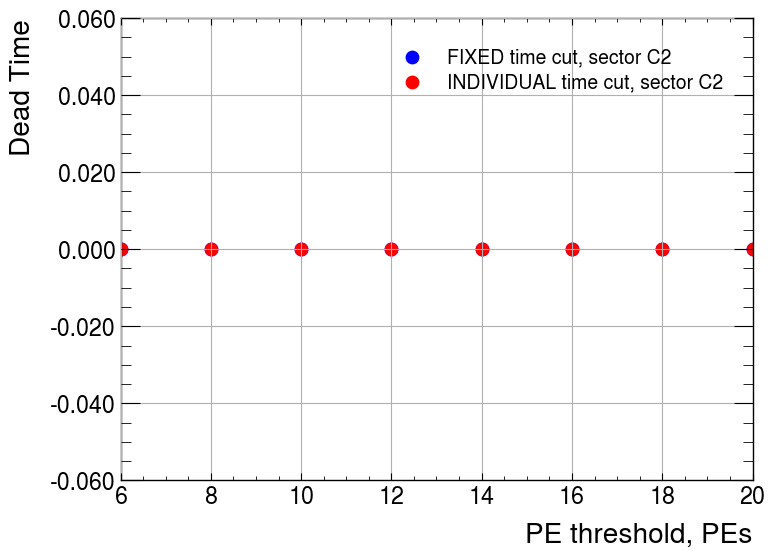

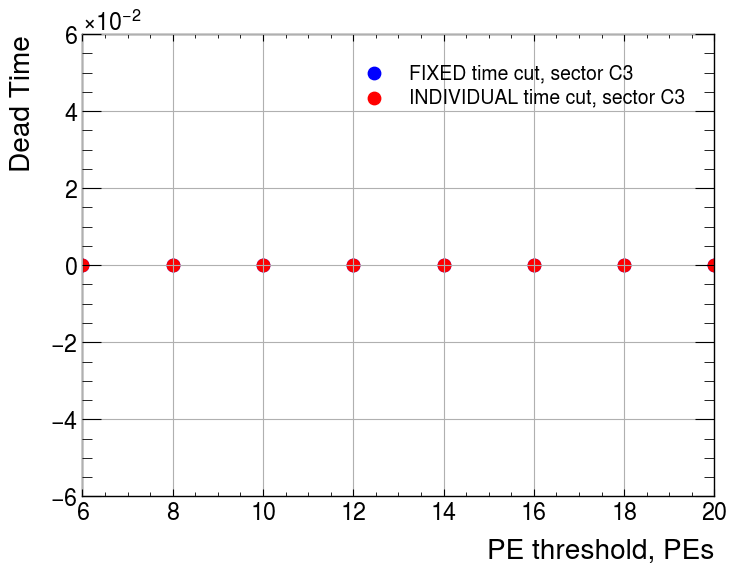

In [86]:
from matplotlib import ticker

#crvSector_list=["NA", "Right", "Left", "Top", "E", "U", "D", "C1", "C2", "C3"]

for sec in crvSector_list:
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
  ax = dfDeadTime.query('`Time cut type` == "DEF" & `Sector Name` == "%s" & `total_PEs_min` == 0'%sec).plot.scatter(x="PEs thr", y="Dead Time", yerr="Error", c='b', label="FIXED time cut, sector %s" % sec, s=80, grid='true')
  dfDeadTime.query('`Time cut type` == "EXT" & `Sector Name` == "%s" & `total_PEs_min` == 0'%sec).plot.scatter(x="PEs thr", y="Dead Time", yerr="Error", c='r', label="INDIVIDUAL time cut, sector %s" % sec, s=80, grid='true', ax=ax)
  ax.set_xlabel("PE threshold, PEs")
  ax.set_ylabel("Dead Time")


In [ ]:
from matplotlib import ticker

#crvSector_list=["NA", "Right", "Left", "Top", "E", "U", "D", "C1", "C2", "C3"]
dfDeadTime = pd.DataFrame(dead_time_sec, columns=['Sector Number', 'Sector Name', 'PEs thr', 'Dead Time', "Error", "Time cut type", "TMIN", "TMAX"])

for sec in crvSector_list:
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
  ax = dfDeadTime.query('`Time cut type` == "DEF" & `Sector Name` == "%s"'%sec).plot.scatter(x="PEs thr", y="Dead Time", yerr="Error", c='b', label="FIXED time cut, sector %s" % sec, s=80, grid='true')
  dfDeadTime.query('`Time cut type` == "EXT" & `Sector Name` == "%s"'%sec).plot.scatter(x="PEs thr", y="Dead Time", yerr="Error", c='r', label="INDIVIDUAL time cut, sector %s" % sec, s=80, grid='true', ax=ax)


In [ ]:
dfDeadTime = pd.DataFrame(dead_time_sec, columns=['Sector Number', 'Sector Name', 'Dead Time', "Error", "Time cut type", "TMIN", "TMAX"])
ax = dfDeadTime.query('`Time cut type` == "DEF"').plot.scatter(x="Sector Name", y="Dead Time", yerr="Error", c='b', label="FIXED time cut", s=80, grid='true')
dfDeadTime.query('`Time cut type` == "EXT"').plot.scatter(x="Sector Name", y="Dead Time", yerr="Error", c='r', label="INDIVIDUAL time cut", s=80, grid='true', ax=ax)
dfDeadTime

Text(0.5, 1.0, 'CRV_E: timeWindowEnd - timeWindowStart')

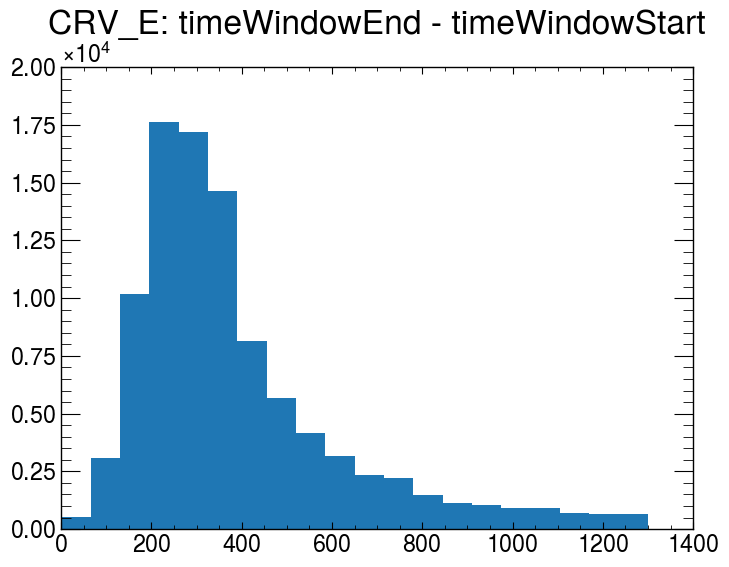

In [ ]:
PEs_thr = 8
plt.hist(dfCE.query('dembestcrv%dPEs_crvSectorType==4' % PEs_thr)['dembestcrv%dPEs_timeWindowEnd' % PEs_thr]- dfCE.query('dembestcrv%dPEs_crvSectorType==4' % PEs_thr)['dembestcrv%dPEs_timeWindowStart' % PEs_thr], bins=20, range=(0,1300));
plt.title("CRV_E: timeWindowEnd - timeWindowStart")


In [ ]:
for sec in range(1,len(crvSector_list)):
  cut_ = "(((de_t0 < dembestcrv%dPEs_timeWindowStart + %d) | (de_t0 > dembestcrv%dPEs_timeWindowEnd + %d)) & dembestcrv%dPEs_crvSectorType == %d)" % (PEs_thr, -time_values[crvSector_list[sec]][1], PEs_thr,  -time_values[crvSector_list[sec]][0], PEs_thr, sec)


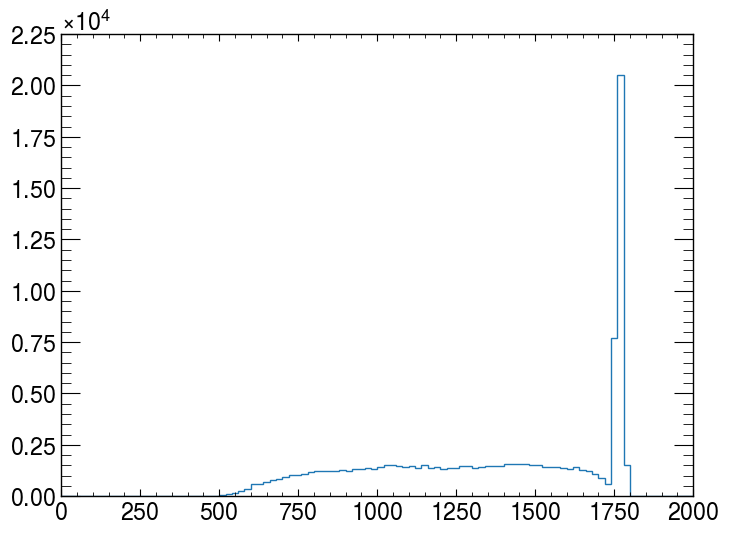

In [ ]:
_PEs_thr = 8
sec = 4
_df = dfCE.query('dembestcrv%dPEs_crvSectorType==%d' % (_PEs_thr, sec))['dembestcrv%dPEs_timeWindowEnd' % _PEs_thr]
plt.hist(_df, bins=100, range=(0,2000), histtype='step', label='Threshold=%dPEs' % _PEs_thr);


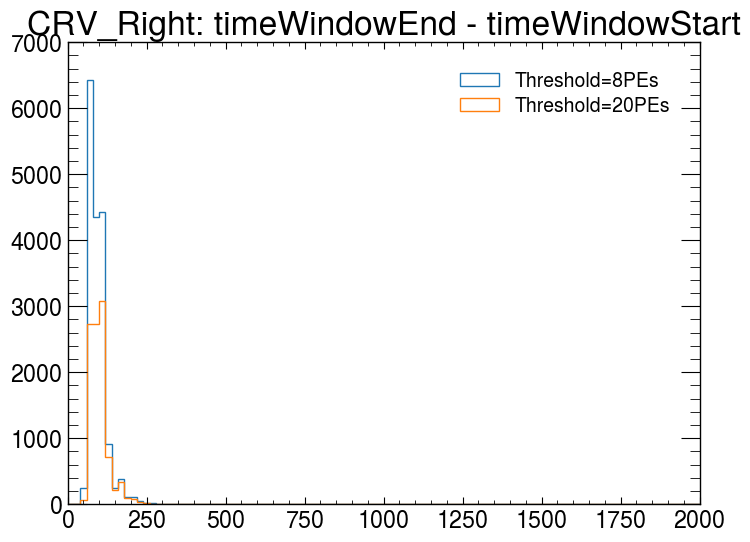

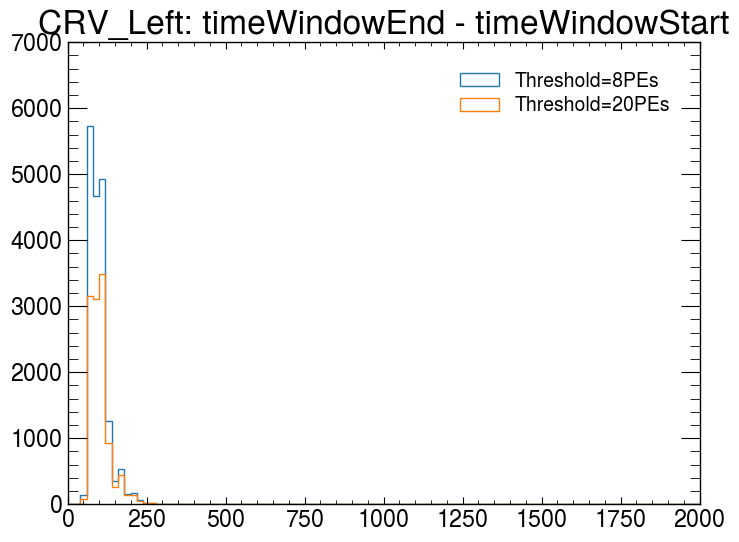

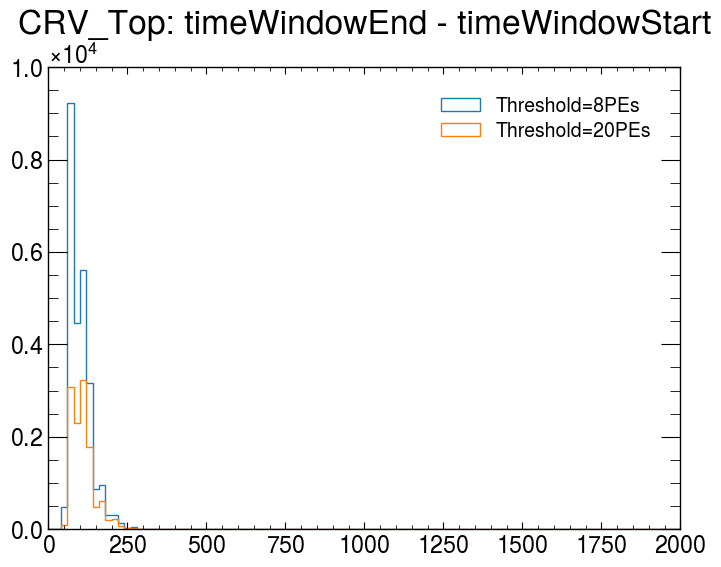

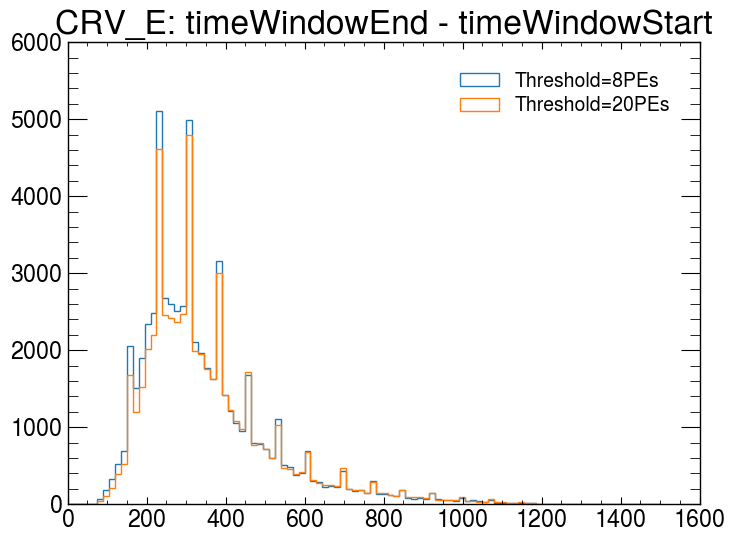

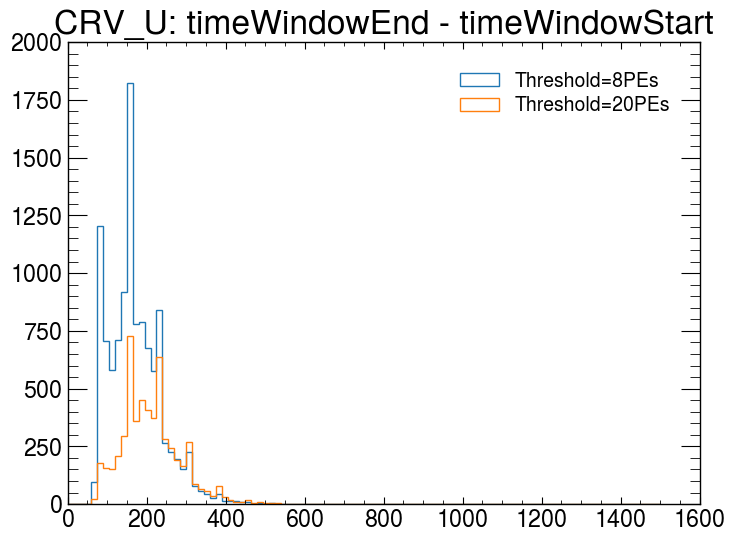

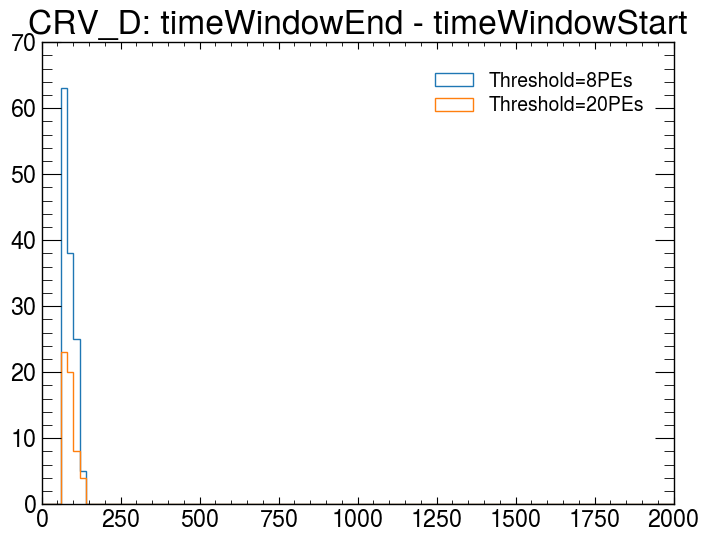

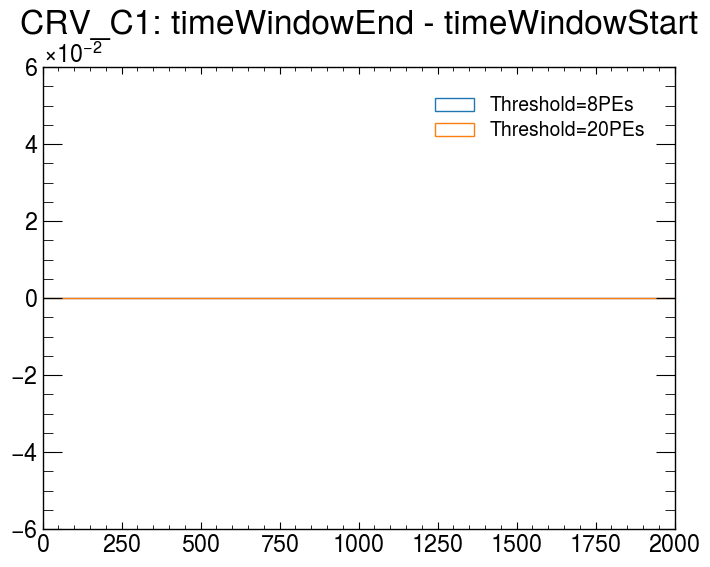

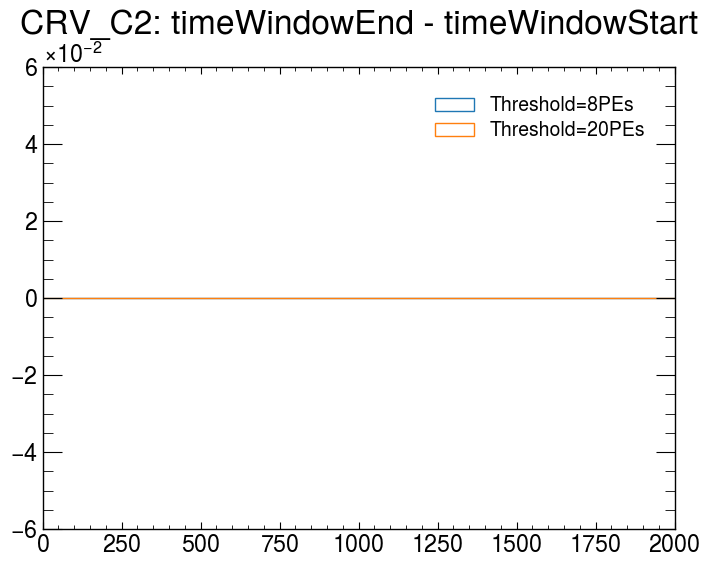

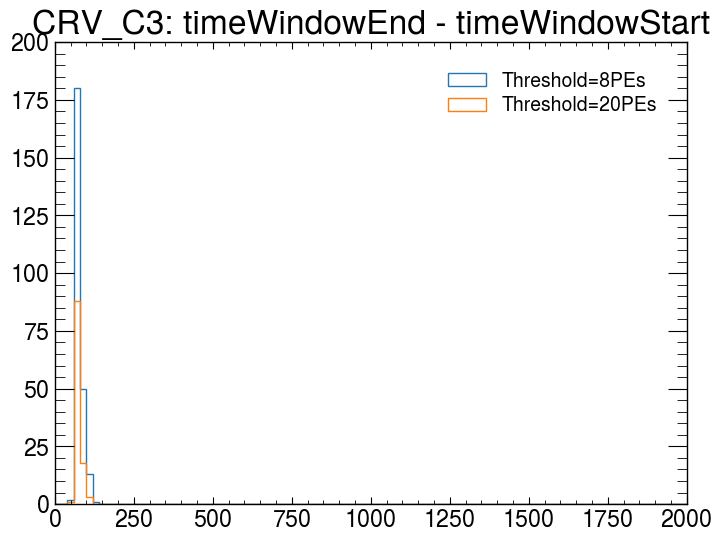

<Figure size 800x600 with 0 Axes>

In [ ]:
#PEs_thresholds = [8, 10, 12, 14, 16, 18, 20]
PEs_thresholds = [8, 20]
for sec in range(1,len(crvSector_list)):
  xmax = 2000
  if sec == 4: xmax = 1500
  if sec == 5: xmax = 1500
  for _PEs_thr in PEs_thresholds:
    _dfCE = dfCE.query('dembestcrv%dPEs_timeWindowStart > 450 & dembestcrv%dPEs_timeWindowStart < 1600 & dembestcrv%dPEs_timeWindowEnd > 450 & dembestcrv%dPEs_timeWindowEnd < 1700' % (_PEs_thr,_PEs_thr,_PEs_thr,_PEs_thr))
    _df = _dfCE.query('dembestcrv%dPEs_crvSectorType==%d' % (_PEs_thr, sec))['dembestcrv%dPEs_timeWindowEnd' % _PEs_thr] - _dfCE.query('dembestcrv%dPEs_crvSectorType==%d' % (_PEs_thr, sec))['dembestcrv%dPEs_timeWindowStart' % _PEs_thr]
    _rand_val = np.random.random(_df.shape[0])*12.6
    _rand_val = 0
    plt.hist(_df + _rand_val, bins=100, range=(0,xmax), histtype='step', label='Threshold=%dPEs' % _PEs_thr);
    plt.legend();
    plt.title("CRV_%s: timeWindowEnd - timeWindowStart" % crvSector_list[sec])
  fig = plt.figure()

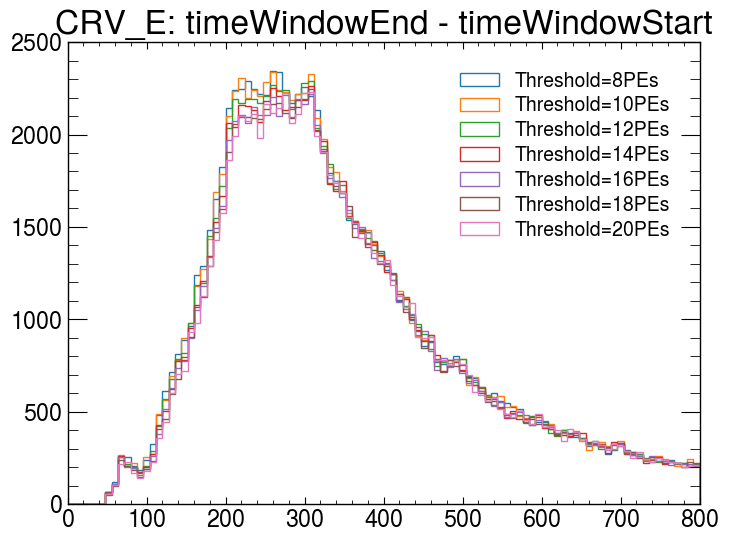

In [ ]:
PEs_thresholds = [8, 10, 12, 14, 16, 18, 20]
for _PEs_thr in PEs_thresholds:
  _df = dfCE.query('dembestcrv%dPEs_crvSectorType==4' % _PEs_thr)['dembestcrv%dPEs_timeWindowEnd' % _PEs_thr] - dfCE.query('dembestcrv%dPEs_crvSectorType==4' % _PEs_thr)['dembestcrv%dPEs_timeWindowStart' % _PEs_thr]
  _rand_val = np.random.random(_df.shape[0])*12.6
  #_rand_val = 0
  plt.hist(_df + _rand_val, bins=100, range=(0,800), histtype='step', label='Threshold=%dPEs' % _PEs_thr);
  plt.legend();
  plt.title("CRV_E: timeWindowEnd - timeWindowStart")


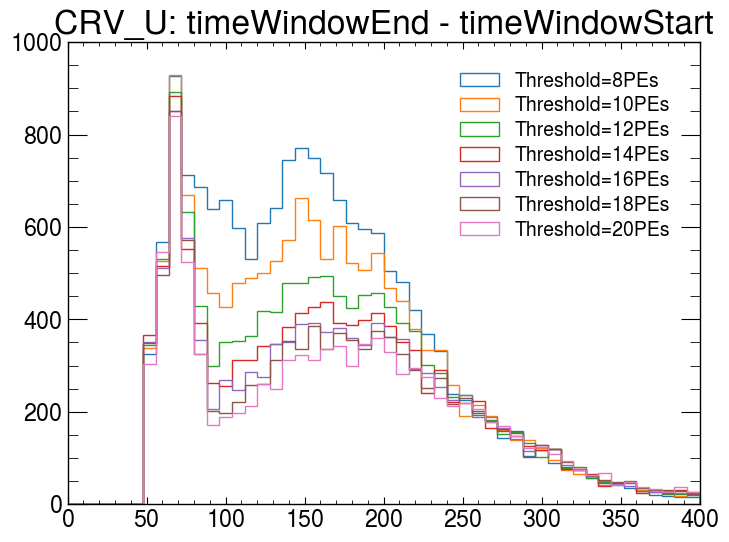

In [ ]:
PEs_thresholds = [8, 10, 12, 14, 16, 18, 20]
#PEs_thresholds = [8, 10]
for _PEs_thr in PEs_thresholds:
  _df = dfCE.query('dembestcrv%dPEs_crvSectorType==5' % _PEs_thr)['dembestcrv%dPEs_timeWindowEnd' % _PEs_thr] - dfCE.query('dembestcrv%dPEs_crvSectorType==5' % _PEs_thr)['dembestcrv%dPEs_timeWindowStart' % _PEs_thr]
  _rand_val = np.random.random(_df.shape[0])*12.6
  #_rand_val = 0
  plt.hist(_df + _rand_val, bins=50, range=(0,400), histtype='step', label='Threshold=%dPEs' % _PEs_thr);
  plt.legend();
  plt.title("CRV_U: timeWindowEnd - timeWindowStart")

In [ ]:
_PEs_thr = 8
(dfCE.query('dembestcrv%dPEs_crvSectorType==5 & crv8PEs_timeWindowEnd > 1200 & crv8PEs_timeWindowEnd < 1220' % _PEs_thr)['dembestcrv%dPEs_timeWindowEnd' % _PEs_thr])
dfCE.query('crv8PEs_crvSectorType==5 & (crv8PEs_timeWindowEnd - crv8PEs_timeWindowStart-60) < 10')['crv8PEs_timeWindowEnd'] - dfCE.query('crv8PEs_crvSectorType==5 & (crv8PEs_timeWindowEnd - crv8PEs_timeWindowStart-60) < 10')['crv8PEs_timeWindowStart']

496       62.750000
605       50.199951
1099      62.750000
1397      50.200073
1617      62.750000
1753      62.750000
1880      50.200073
1942      62.750000
2439      62.750000
2479      50.200073
2495      50.200073
2634      50.199951
2993      62.750000
3247      62.750000
3593      62.750000
3910      62.750000
4378      62.750000
5798      62.750000
6225      62.750000
6226      50.199951
6441      50.200195
6561      50.199951
6999      62.750000
7145      62.750000
7452      50.200073
7589      50.199951
7600      50.199951
7601      62.750000
7945      62.750000
7952      62.750000
8019      62.750000
8031      62.750000
8151      62.750000
8612      62.750000
8613      62.750000
8915      50.199951
8933      62.750000
9194      50.199951
9309      50.199951
9668      50.200073
10248     62.750061
10398     62.750000
10787     50.200073
11122     50.200073
11217     62.750000
11222     62.750000
11446     62.750000
11572     62.750000
11903     50.200073
11905     62.750000


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

dfCE.query(cut_current + "&" + "crv8PEs_crvSectorType < 9")
list(dfCE)

(400.0, 1750.0)

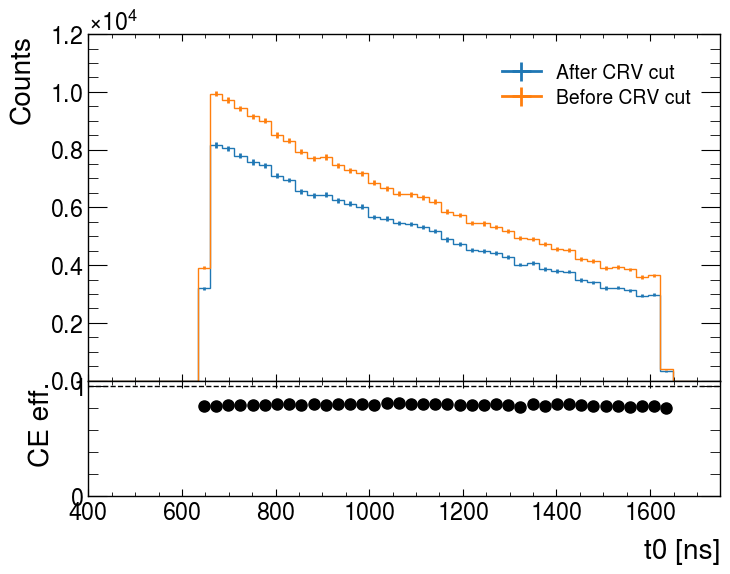

In [ ]:
cut_current = cut_extmom+" & "+crv_time
#cut_current = cut_extmom+" & "+crv_time_ext
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(50, 400, 1700, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
)

h.fill(cat="all", x=dfCE.query(cut_extmom)['de_t0'].to_numpy())
h.fill(cat="cut", x=dfCE.query(cut_current)['de_t0'].to_numpy());

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.0, 1.05], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('CE eff.')
fig.get_axes()[1].set_xlim(400,1750)



In [ ]:
#neve_extmom = len(dfCRY5.query(cut_extmom))
neve_extmom = len(dfCRY5.query(cut_tbox))

neve_physmom = len(dfCRY5.query(cut_phymom))
mom_scale = neve_extmom/neve_physmom

print(mom_scale)

label = r'$\frac{P_{ext}}{P_{phy}} = %.1f$' % mom_scale
_, bins, _ = plt.hist(dfCRY5.query(cut_nomom)['deent_mom'], bins=120, range=[50, 170], histtype='step', label='No momentum');
plt.hist(dfCRY5.query(cut_extmom)['deent_mom'], bins=bins, histtype='step', label='Extended momentum');
plt.axvline(PMIN_PHY, color='r', linestyle='--', linewidth=1)
plt.axvline(PMAX_PHY, color='r', linestyle='--', label='Physics momentum', linewidth=1)
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Momentum [MeV]')

plt.figure()
plt.hist(dfCRY5.query(cut_extmom)['crv_dT'], bins=100, range=(-200, 100), histtype='step',  density=True, label='Extended momentum');
plt.hist(dfCRY5.query(cut_phymom)['crv_dT'], bins=100, range=(-200, 100), histtype='step',  density=True, label='Physics momentum');
plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut')
#plt.ylim(0)
#plt.yscale('log')
plt.xlabel(r'$\Delta$ T (CRV-Tracker) [ns]');
plt.legend(loc='upper left', prop={'size': 16})
plt.yscale('log')

In [ ]:
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(10, 400, 1800, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
)

cut_tmp=cut_extmom+'&' + 'ue_status <= 0 & abs(demcpri_pdg) == 13 & crvsummarymc_crvSectorType>-9999'
h.fill(cat="all", x=dfCRY5.query(cut_tmp + '& is_high==0')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_LO_CRY5)
h.fill(cat="all", x=dfCRY5.query(cut_tmp + '& is_high==1')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_HI_CRY5)
cut_tmp = cut_tmp +'&'+crv_time
h.fill(cat="cut", x=dfCRY5.query(cut_tmp + '& is_high==0')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_LO_CRY5);
h.fill(cat="cut", x=dfCRY5.query(cut_tmp + '& is_high==1')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_HI_CRY5);

import matplotlib.ticker

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.000002, 0.009], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('Inefficiency')
fig.get_axes()[1].set_yscale('log')
fig.get_axes()[0].set_yscale('log')
fig.get_axes()[1].axhline(0.0001,color='black',ls='--', linewidth=0.7)
fig.get_axes()[1].axhline(0.001,color='red',ls='-.', linewidth=0.7)

In [ ]:
plt.hist(dfCRY5['crvsummarymc_crvSectorType'], range=(-1,10), bins=11, histtype='step');
plt.xlabel('CRV type');
plt.yscale('log')

In [ ]:
crvSector_list=["NA", "Right", "Left", "Top", "CRV-E", "CRV-U", "CRV-D", "CRV-C1", "CRV-C2", "CRV-C3"]

for sector in range(0,10):
  dfCRY5_ = dfCRY5.query('crvsummarymc_crvSectorType==%d'%sector)
  plt.plot(dfCRY5_['crvsummarymc_z'], dfCRY5_['crvsummarymc_x'], '.', markersize=3, label=crvSector_list[sector])
  plt.legend(bbox_to_anchor=(1, 1.0),markerscale=5)

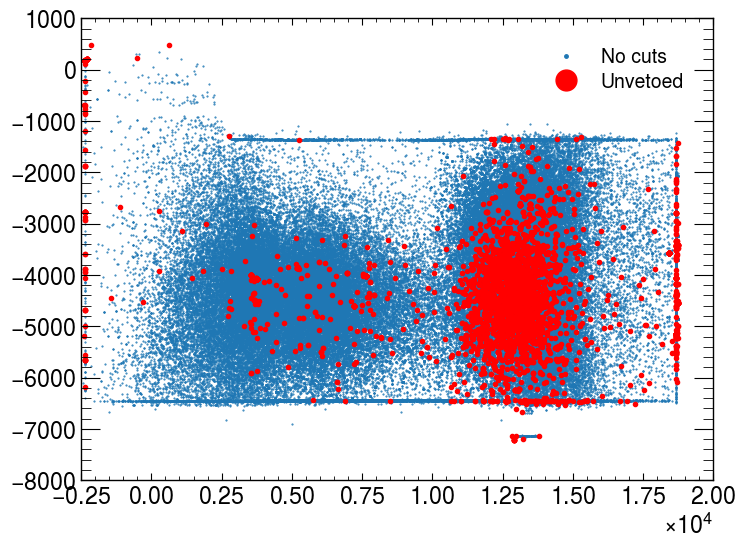

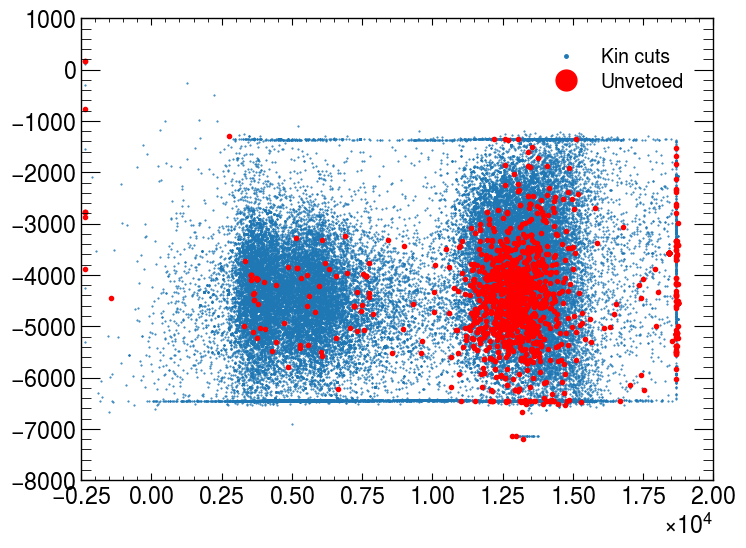

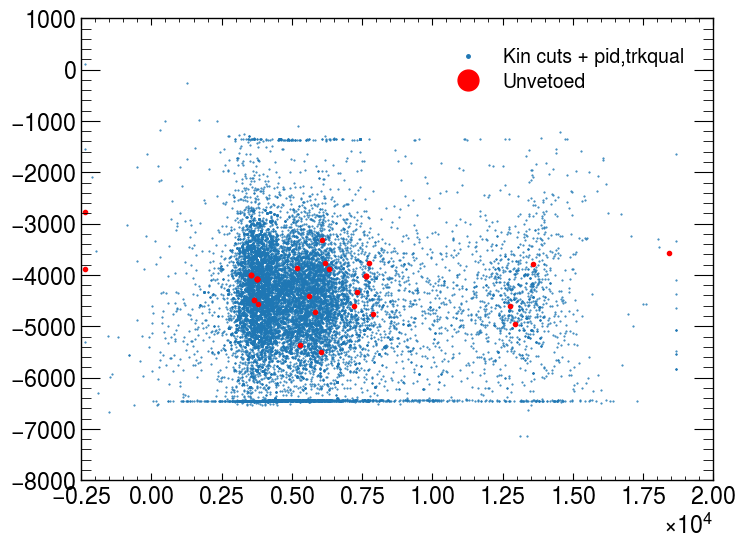

In [ ]:
dfCRY5_ = dfCRY5.query('crvsummarymc_crvSectorType>0')
plt.plot(dfCRY5_['crvsummarymc_z'], dfCRY5_['crvsummarymc_x'], '.', markersize=1, label="No cuts")
plt.plot(dfCRY5_.query('crv20PEs_timeWindowStart<10')['crvsummarymc_z'], dfCRY5_.query('crv20PEs_timeWindowStart<10')['crvsummarymc_x'], 'r.', markersize=6, label="Unvetoed")
plt.legend(markerscale=5);

plt.figure()
dfCRY5_ = dfCRY5.query('crvsummarymc_crvSectorType>0 & '+cut_tbox)
plt.plot(dfCRY5_['crvsummarymc_z'], dfCRY5_['crvsummarymc_x'], '.', markersize=1, label="Kin cuts")
plt.plot(dfCRY5_.query('crv20PEs_timeWindowStart<10')['crvsummarymc_z'], dfCRY5_.query('crv20PEs_timeWindowStart<10')['crvsummarymc_x'], 'r.', markersize=6, label="Unvetoed")
plt.legend(markerscale=5);

plt.figure()
dfCRY5_ = dfCRY5.query('crvsummarymc_crvSectorType>0 & '+cut_extmom)
plt.plot(dfCRY5_['crvsummarymc_z'], dfCRY5_['crvsummarymc_x'], '.', markersize=1, label="Kin cuts + pid,trkqual")
plt.plot(dfCRY5_.query('crv20PEs_timeWindowStart<10')['crvsummarymc_z'], dfCRY5_.query('crv20PEs_timeWindowStart<10')['crvsummarymc_x'], 'r.', markersize=6, label="Unvetoed")
plt.legend(markerscale=5);

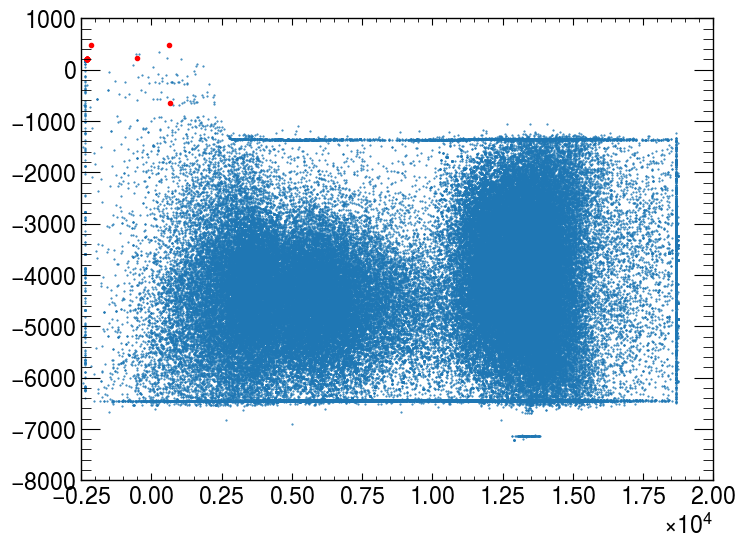

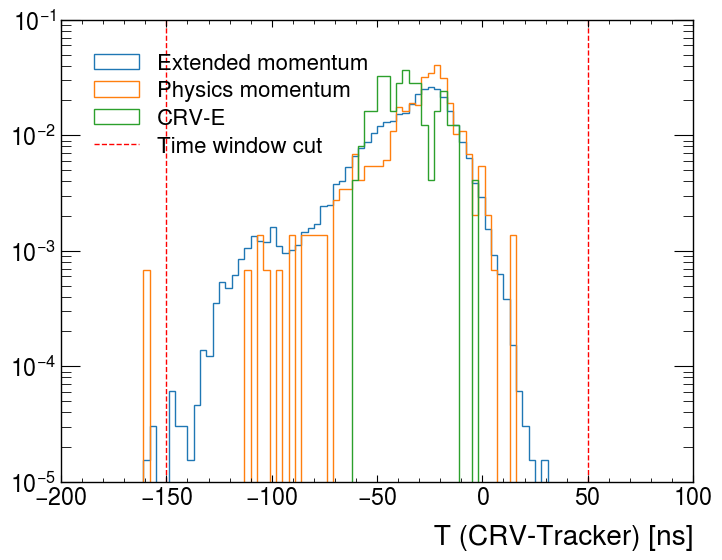

In [ ]:
#crvSector_list=["NA", "Right", "Left", "Top", "CRV-E", "CRV-U", "CRV-D", "CRV-C1", "CRV-C2", "CRV-C3"]

dfCRY5_ = dfCRY5.query('crvsummarymc_crvSectorType>0')
plt.plot(dfCRY5_['crvsummarymc_z'], dfCRY5_['crvsummarymc_x'], '.', markersize=1, label="Kin cuts + pid,trkqual")
crv_time_ = "(de_t0 < crv%dPEs_timeWindowStart + %d | de_t0 > crv%dPEs_timeWindowEnd + %d) & abs(demcpri_pdg) == 13 & crvsummarymc_crvSectorType == %d" % (8, -TMAX, 8,  -TMIN, 4)
plt.plot(dfCRY5_.query(crv_time_)['crvsummarymc_z'], dfCRY5_.query(crv_time_)['crvsummarymc_x'], 'r.', markersize=6, label="Unvetoed")

plt.figure()
plt.hist(dfCRY5.query(cut_extmom)['crv_dT'], bins=100, range=(-200, 100), histtype='step',  density=True, label='Extended momentum');
plt.hist(dfCRY5.query(cut_phymom)['crv_dT'], bins=100, range=(-200, 100), histtype='step',  density=True, label='Physics momentum');
plt.hist(dfCRY5.query('crvsummarymc_crvSectorType==4')['crv_dT'], histtype='step', density=True, range=(-200,100), bins=100, label='CRV-E');

plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut')
plt.xlabel(r' T (CRV-Tracker) [ns]');
plt.legend(loc='upper left', prop={'size': 16})
plt.yscale('log')

In [ ]:
dfCRY5_.query(crv_time_)[['evtinfo_subrunid', 'evtinfo_eventid', 'de_t0','crvsummarymc_x','crvsummarymc_z', 'crvsummary_nHitCounters', 'crvsummary_totalPEs', 'crv8PEs_timeWindowStart', 'crv8PEs_timeWindowEnd', 'de_t0', 'crvsummarymc_nHitCounters', 'crvsummarymc_totalEnergyDeposited', 'is_high']]

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


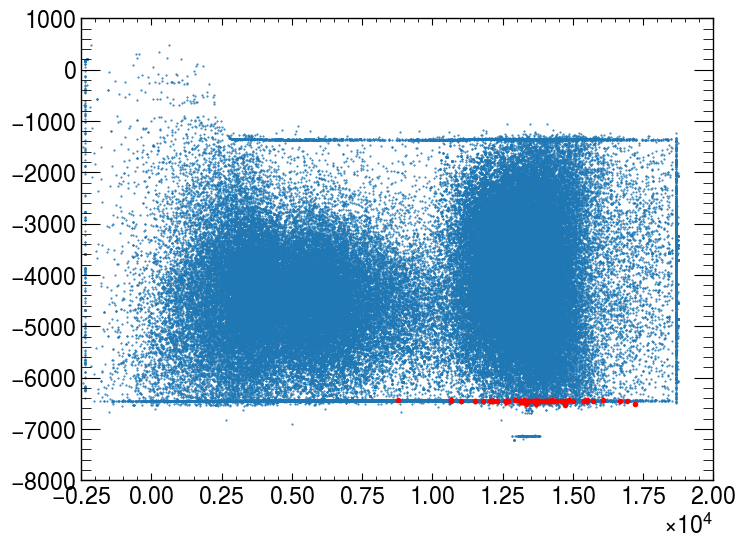

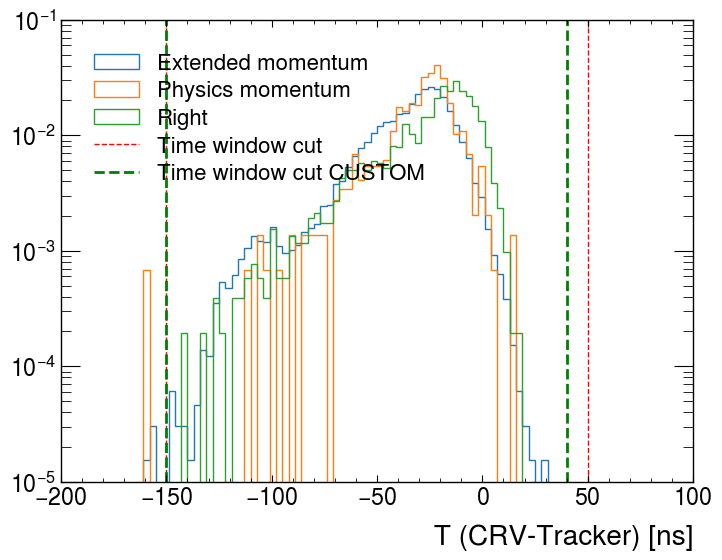

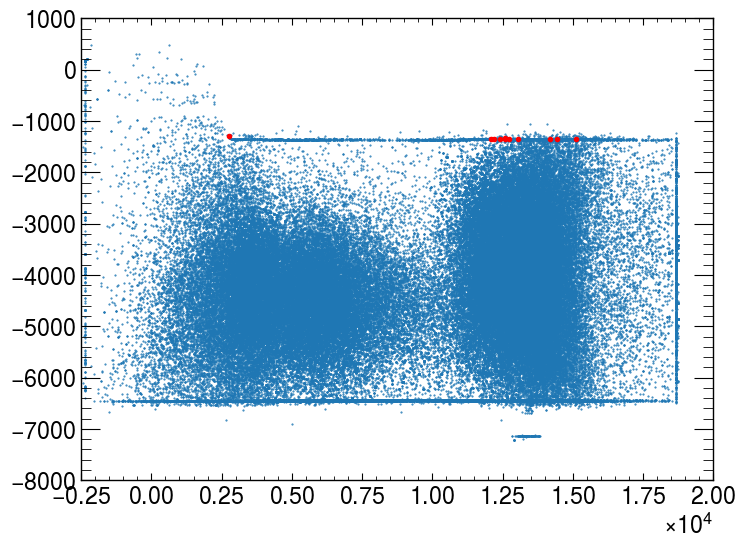

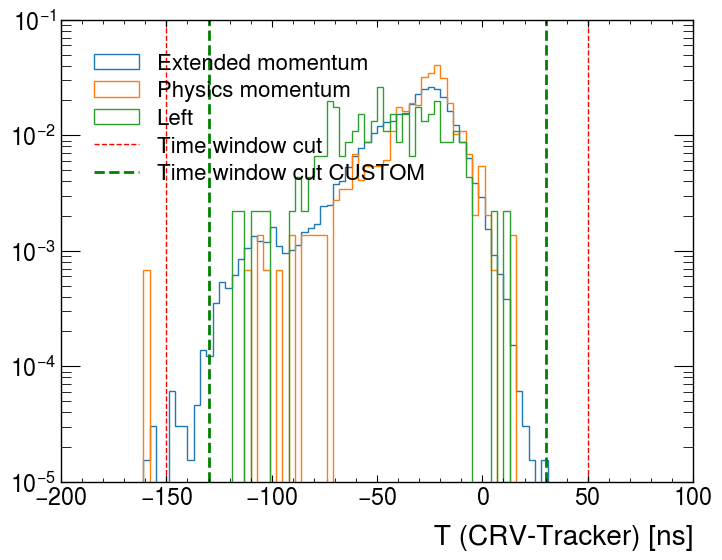

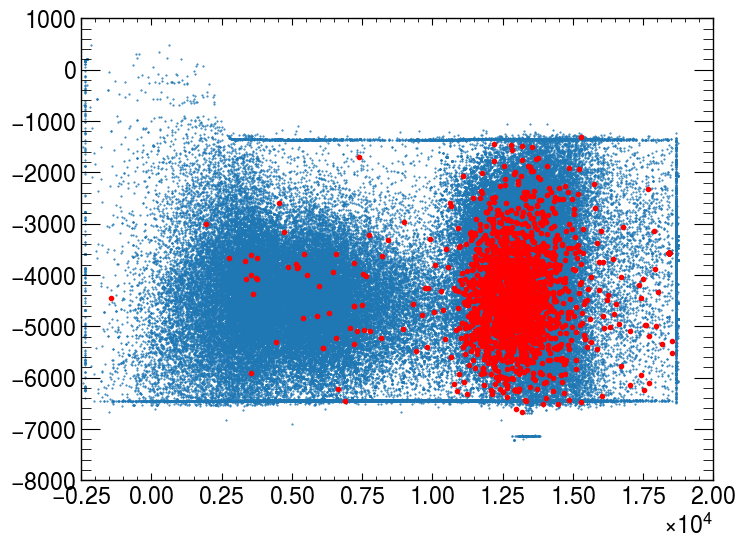

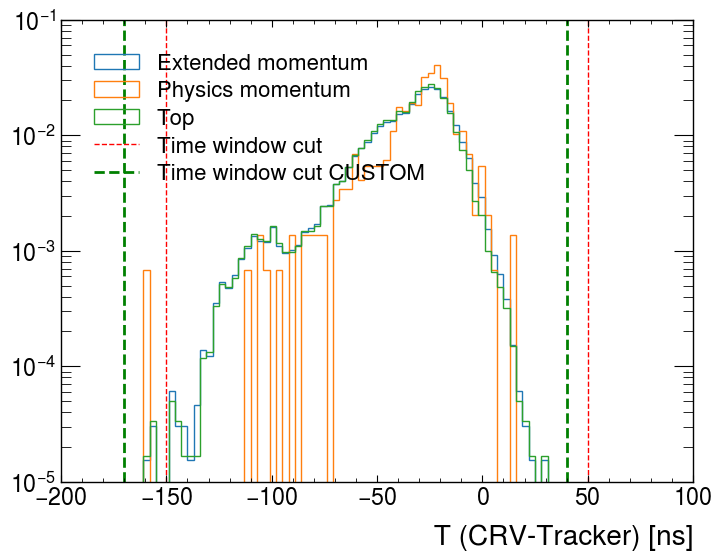

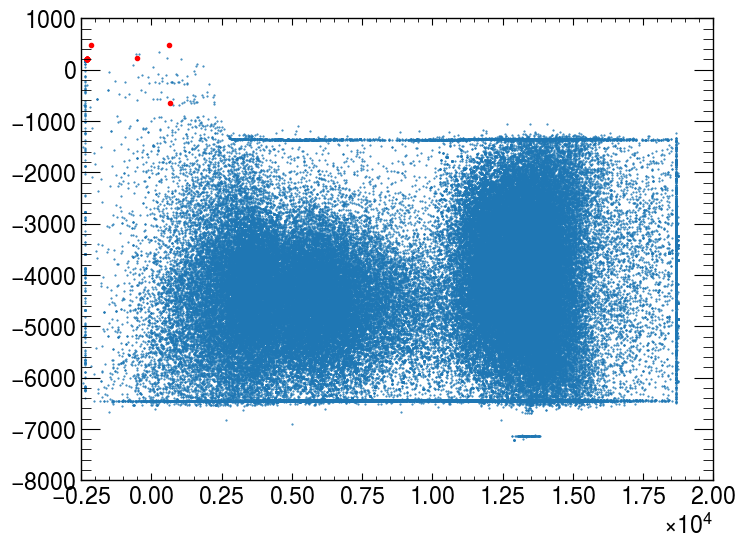

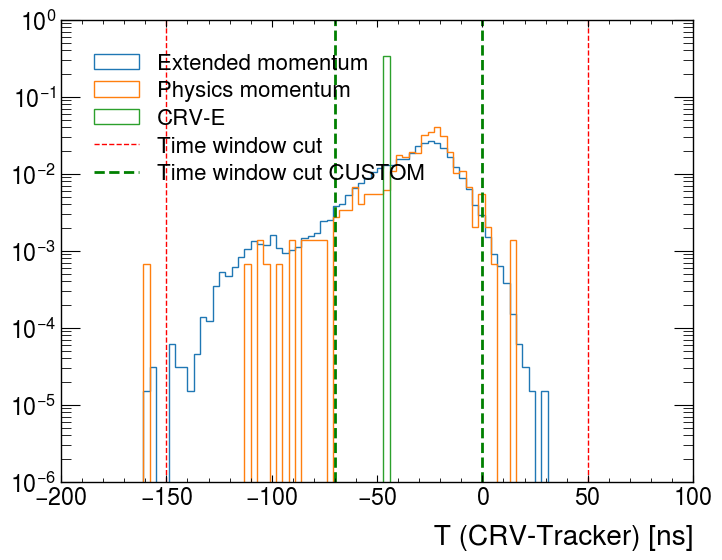

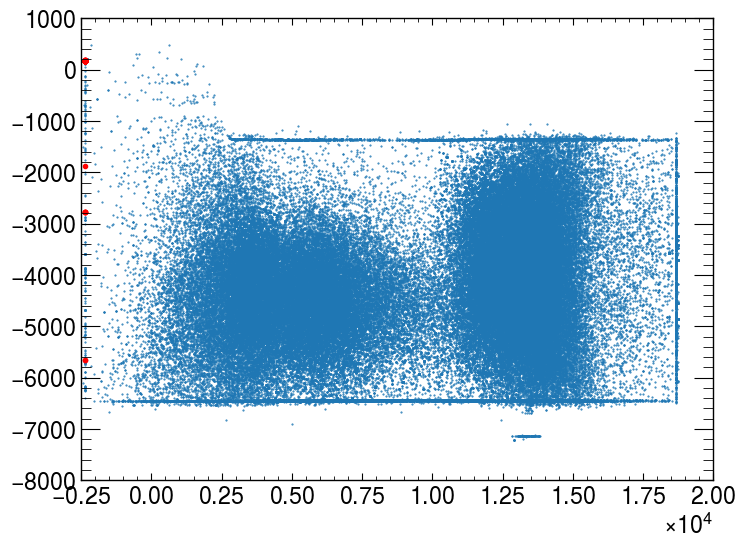

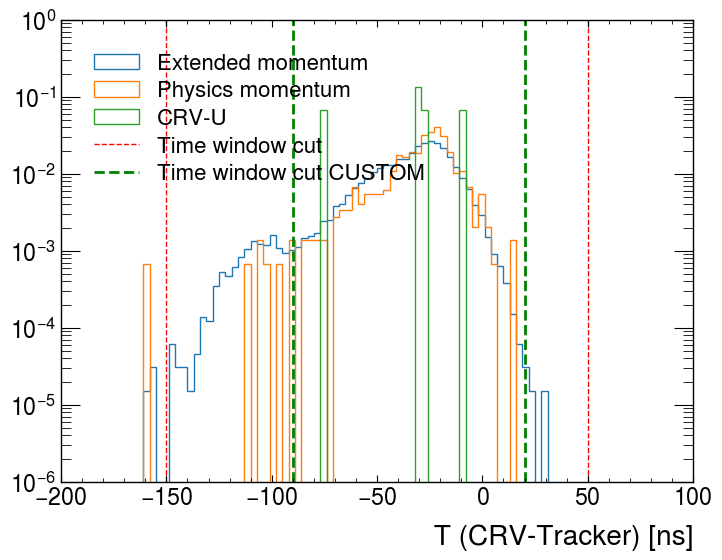

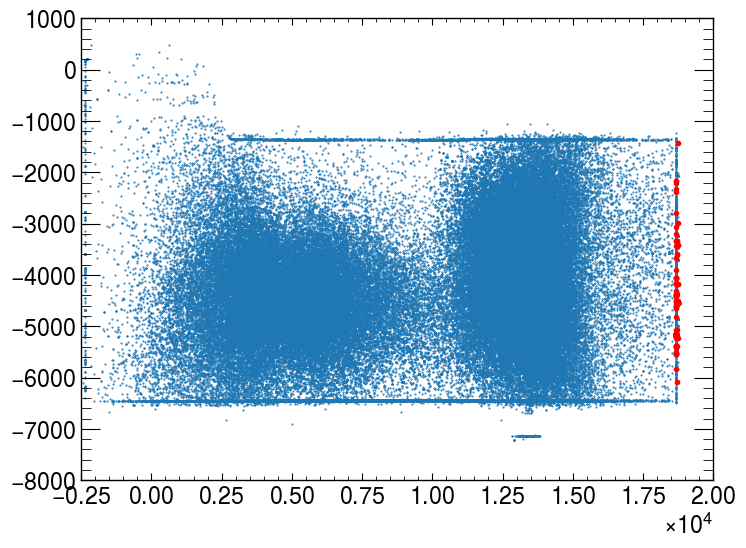

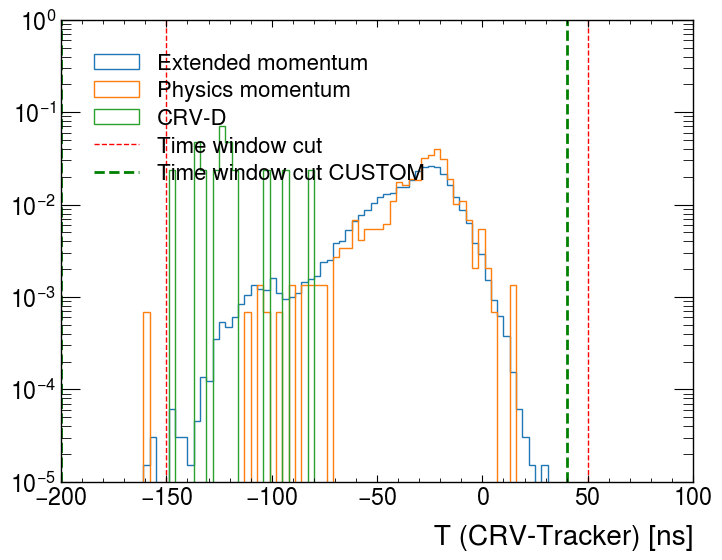

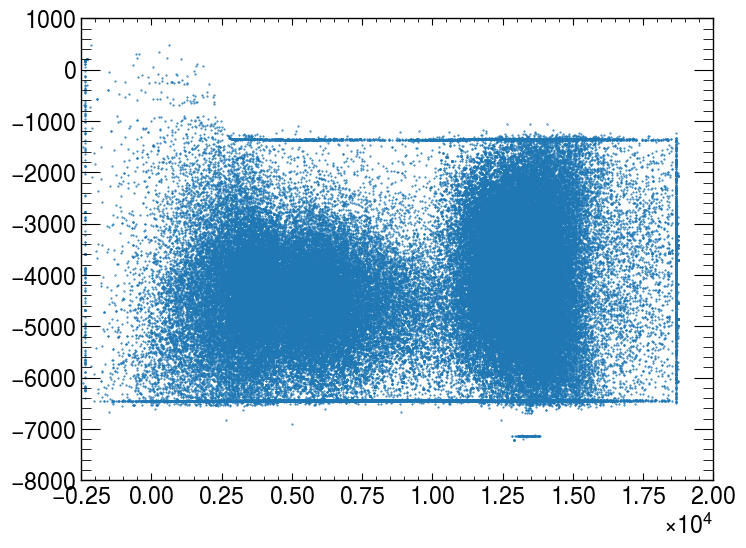

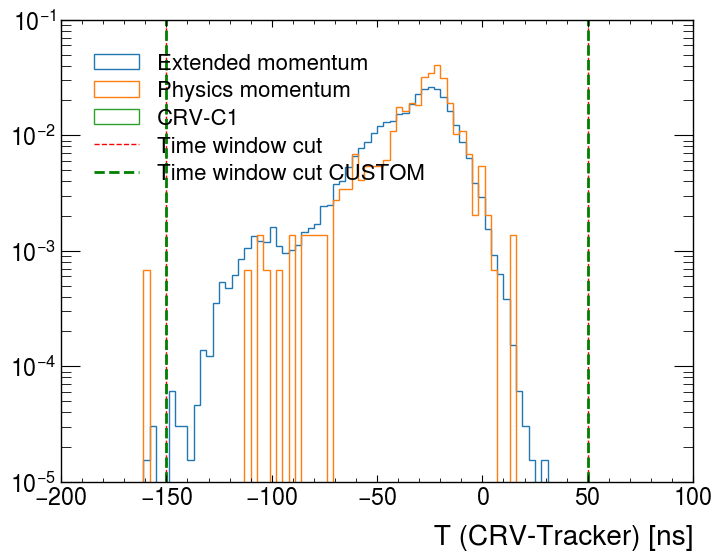

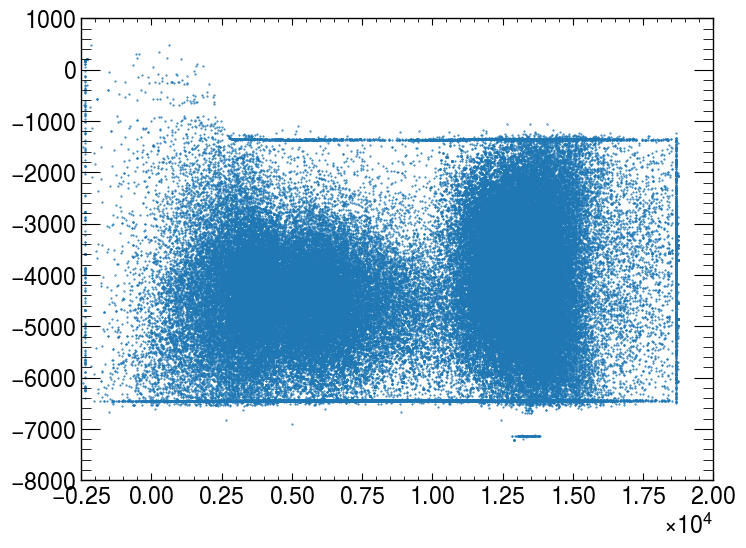

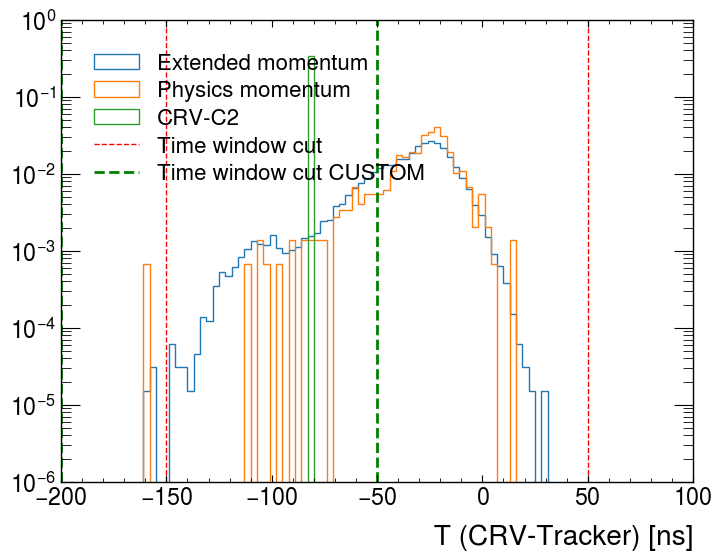

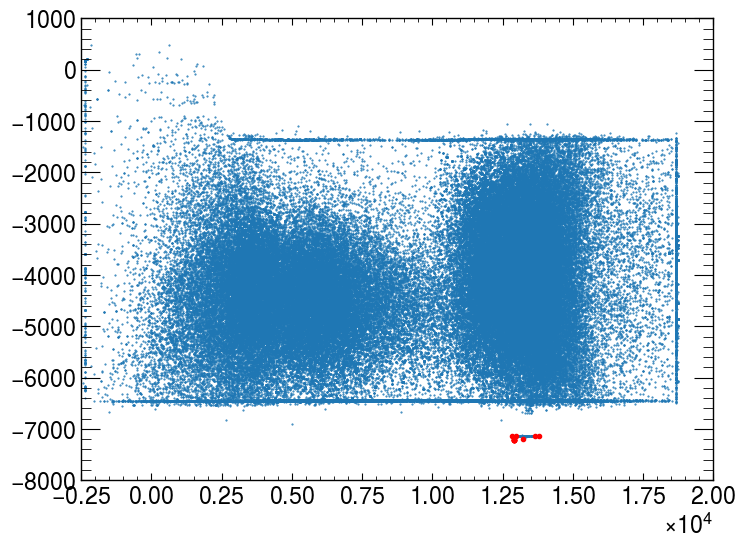

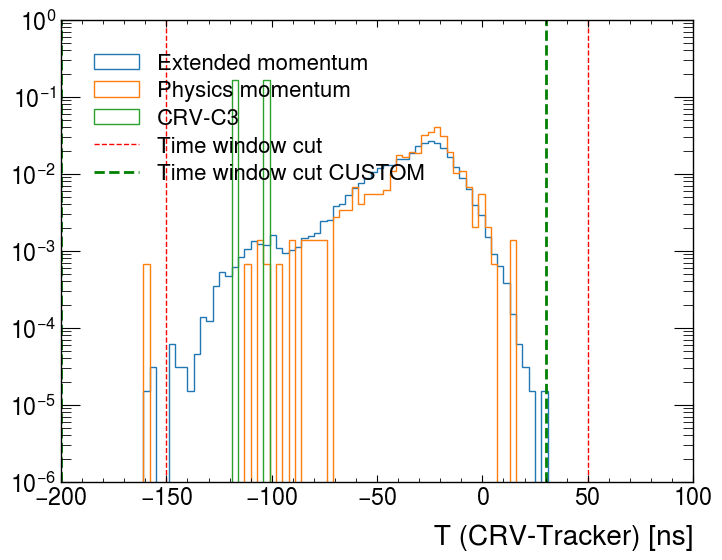

In [ ]:
use_ext_cut = True

#if(use_ext_cut):
#  cut=cut_current
#else:
#  cut=" 1"

for sec in range(1,len(crvSector_list)):

  plt.figure()
  plt.plot(dfCRY5_['crvsummarymc_z'], dfCRY5_['crvsummarymc_x'], '.', markersize=1, label="Kin cuts + pid,trkqual")
  crv_time_ = "(de_t0 < crv%dPEs_timeWindowStart + %d | de_t0 > crv%dPEs_timeWindowEnd + %d) & abs(demcpri_pdg) == 13 & crvsummarymc_crvSectorType == %d" % (8, -TMAX, 8,  -TMIN, sec)
  plt.plot(dfCRY5_.query(crv_time_)['crvsummarymc_z'], dfCRY5_.query(crv_time_)['crvsummarymc_x'], 'r.', markersize=6, label="Unvetoed")

  plt.figure()
  plt.hist(dfCRY5.query(cut_extmom)['crv_dT'], bins=100, range=(-200, 100), histtype='step',  density=True, label='Extended momentum');
  plt.hist(dfCRY5.query(cut_phymom)['crv_dT'], bins=100, range=(-200, 100), histtype='step',  density=True, label='Physics momentum');
  if(use_ext_cut):
    plt.hist(dfCRY5.query('crvsummarymc_crvSectorType==%d & %s'%(sec,cut_extmom))['crv_dT'], histtype='step', density=True, range=(-200,100), bins=100, label=crvSector_list[sec]);
  else:
    plt.hist(dfCRY5.query('crvsummarymc_crvSectorType==%d'%sec)['crv_dT'], histtype='step', density=True, range=(-200,100), bins=100, label=crvSector_list[sec]);

  plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
  plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut')
  plt.axvline(time_values[crvSector_list[sec]][0], color='g', linestyle='--', linewidth=2)
  plt.axvline(time_values[crvSector_list[sec]][1], color='g', linestyle='--', linewidth=2, label='Time window cut CUSTOM')


  plt.xlabel(r' T (CRV-Tracker) [ns]');
  plt.legend(loc='upper left', prop={'size': 16})
  plt.yscale('log')

  if(use_ext_cut):
    plt.savefig("drive/MyDrive/Mu2e/ImagesFromColab/CRV_time_WITH_CUT_sec_%d_%s" % (sec,crvSector_list[sec]))
  else:
    plt.savefig("drive/MyDrive/Mu2e/ImagesFromColab/CRV_time_NO_CUT_sec_%d_%s" % (sec,crvSector_list[sec]))



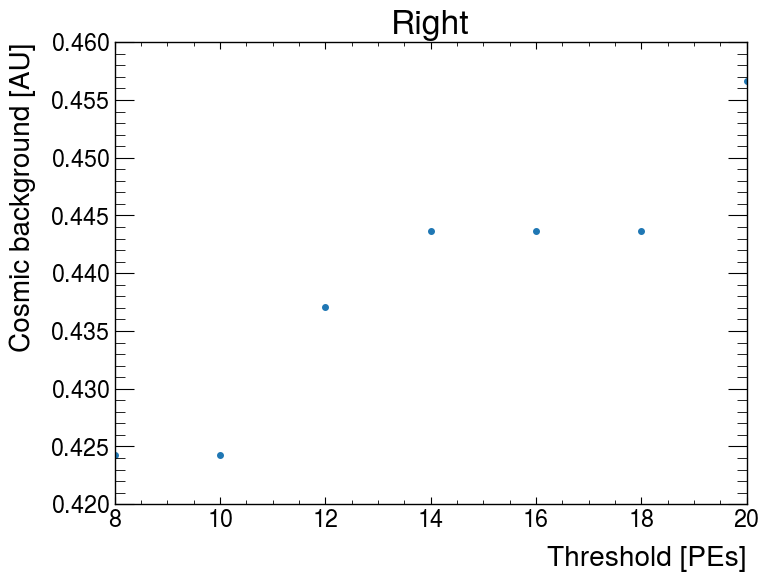

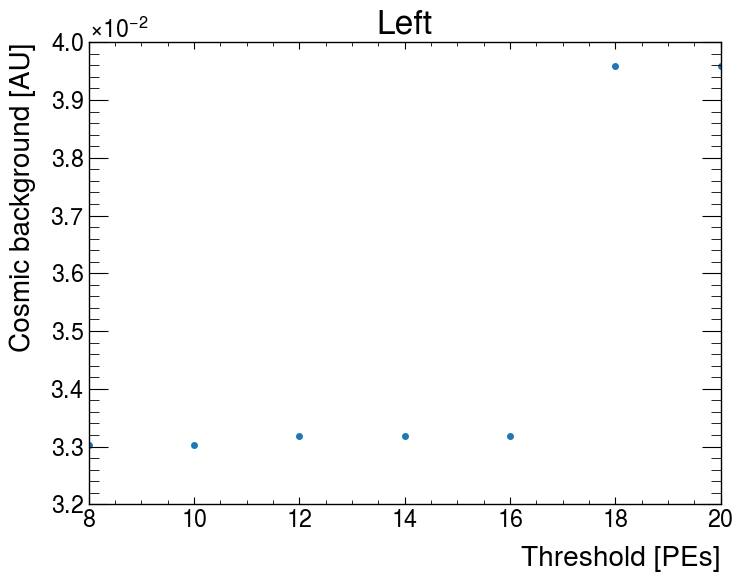

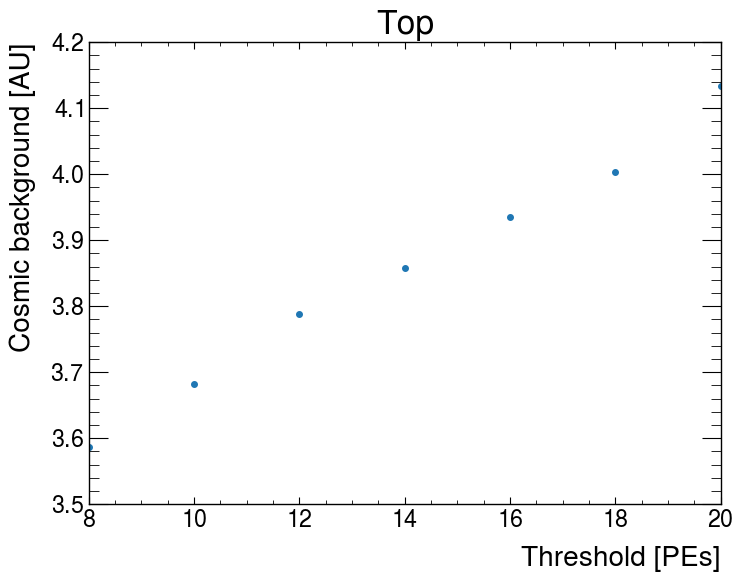

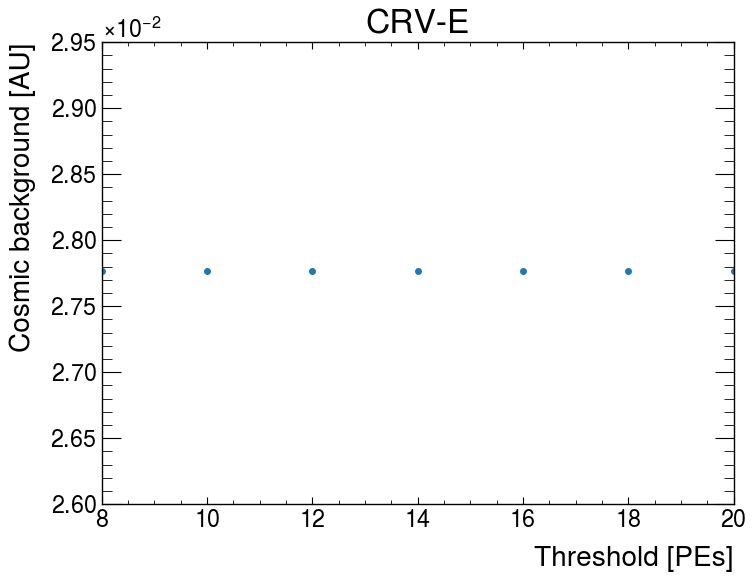

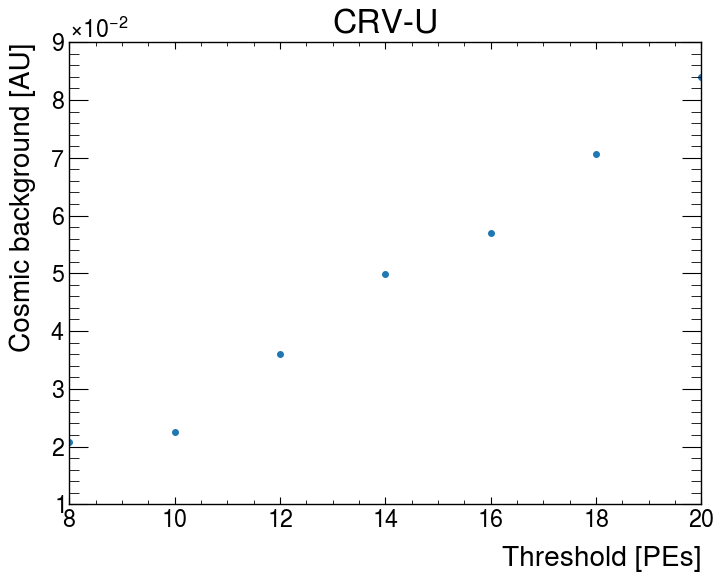

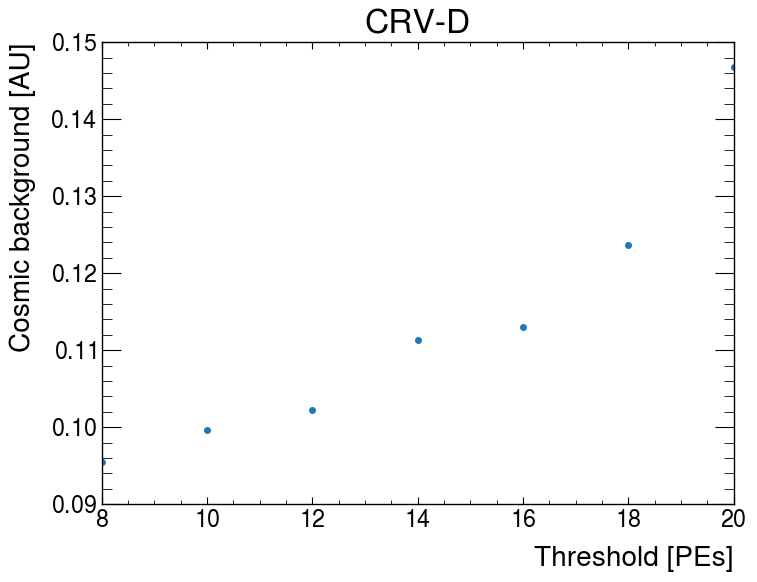

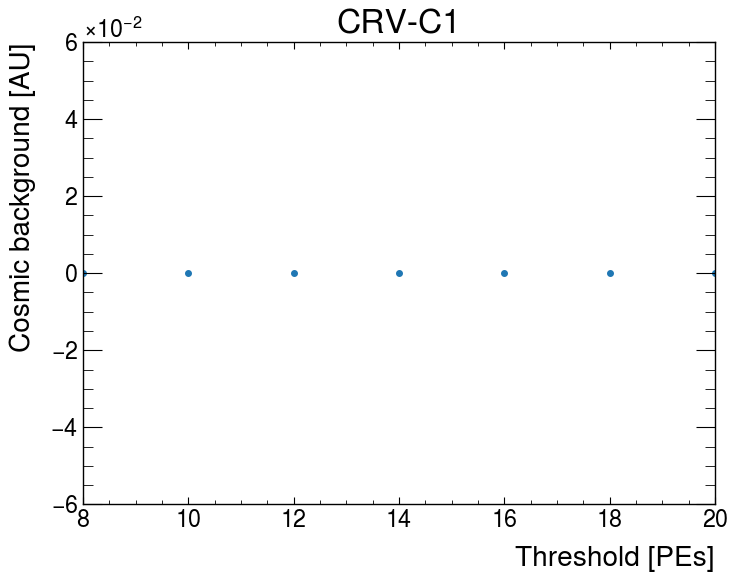

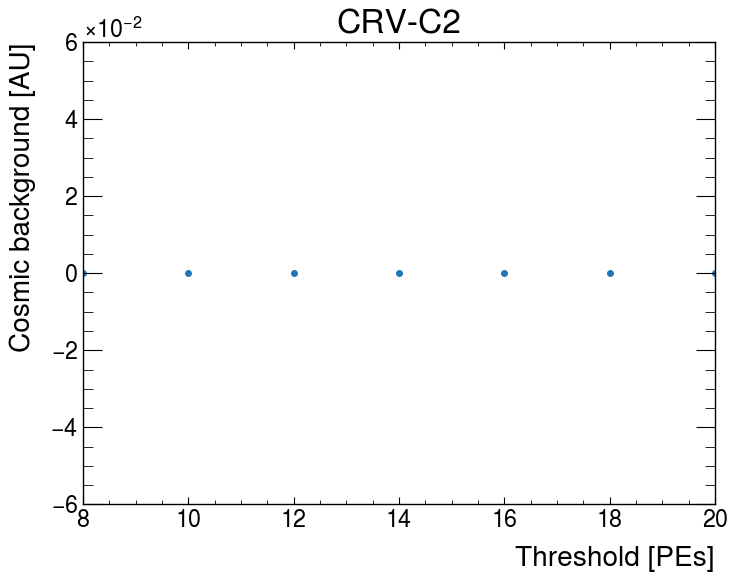

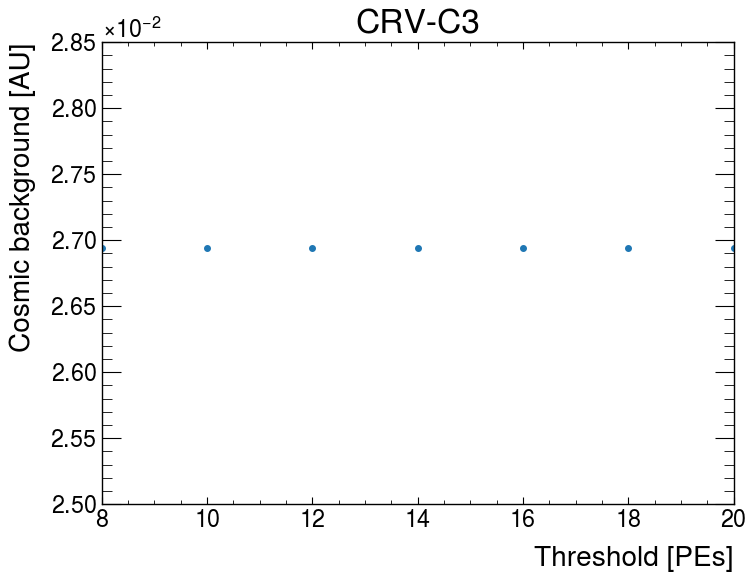

In [ ]:
th_list=[8,10,12,14,16,18,20]
def plot_background(crvSector):
  bg_list=[]
  for th in th_list:
    crv_time_ = "(de_t0 < crv%dPEs_timeWindowStart + %d | de_t0 > crv%dPEs_timeWindowEnd + %d) & abs(demcpri_pdg) == 13 & crvsummarymc_crvSectorType == %d" % (th, -TMAX, th,  -TMIN, crvSector)
#    bg = utils.getNormBackground(dfCRY5, cut_tbox+"&"+crv_time_, mom_scale, utils.LIVETIME_LO_CRY5, utils.LIVETIME_HI_CRY5)
    bg = utils.getNormBackground(dfCRY5, crv_time_, mom_scale, utils.LIVETIME_LO_CRY5, utils.LIVETIME_HI_CRY5)
    bg_list.append(bg[0])
  plt.figure()
  plt.plot(th_list, bg_list, '.')
  plt.ylabel("Cosmic background [AU]");
  plt.xlabel("Threshold [PEs]");
  plt.title(crvSector_list[sector])
#  plt.ylim(0,2)

for sector in range(1,10):
  plot_background(sector)


#Background estimation: production sources

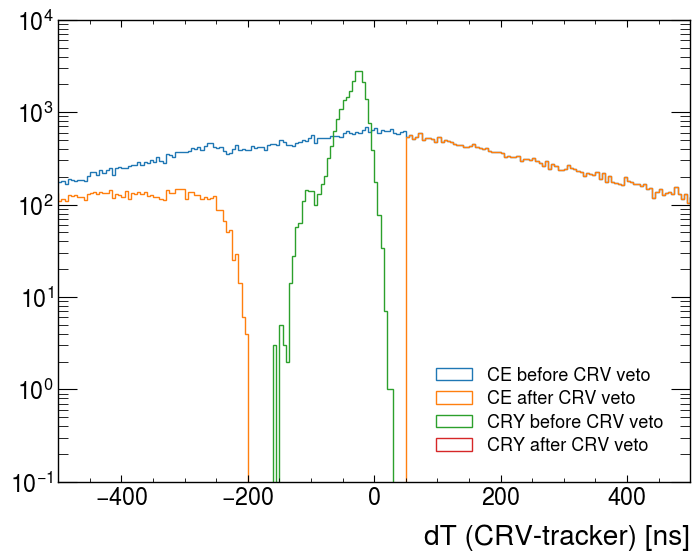

In [ ]:
dfCE['crvinfo_timeWindowEnd'] = dfCE['crv8PEs_timeWindowEnd']
dfCE['crvinfo_timeWindowStart'] = dfCE['crv8PEs_timeWindowStart']
dfCE['crvinfo_dTs'] = dfCE['crv8PEs_timeWindowStart'] - dfCE['de_t0']

dfCRY5['crvinfo_timeWindowEnd'] = dfCRY5['crv8PEs_timeWindowEnd']
dfCRY5['crvinfo_timeWindowStart'] = dfCRY5['crv8PEs_timeWindowStart']
dfCRY5['crvinfo_dTs'] = dfCRY5['crv8PEs_timeWindowStart'] - dfCRY5['de_t0']

plt.hist(dfCE.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], bins=400, range=(-1000, 1000), histtype='step', label='CE before CRV veto');
plt.hist(dfCE.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], bins=400, range=(-1000, 1000), histtype='step', label='CE after CRV veto');
plt.hist(dfCRY5.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], histtype='step', bins=400, range=(-1000, 1000), label='CRY before CRV veto');
plt.hist(dfCRY5.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], histtype='step', bins=400, range=(-1000, 1000), label='CRY after CRV veto');

plt.xlabel('dT (CRV-tracker) [ns]')
plt.legend(fontsize=13)
plt.xlim(-500, 500)
plt.yscale('log')

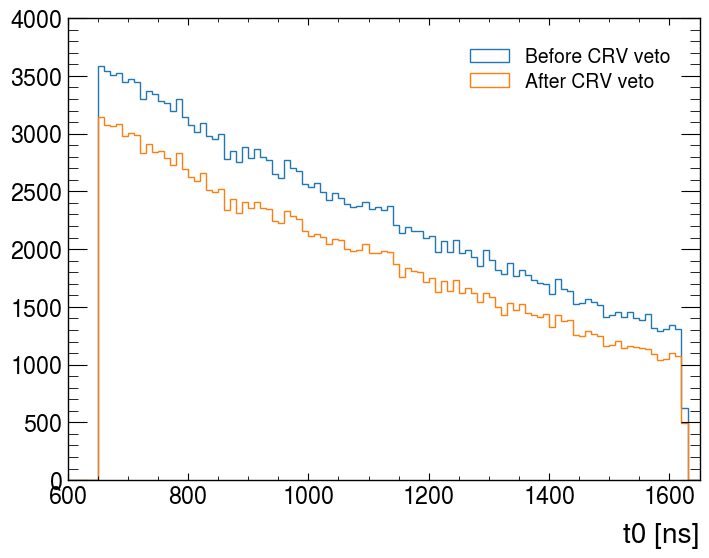

In [ ]:
plt.hist(dfCE.query(cut_extmom+" & " + cut_t0+" & " + crv_live_window)['de_t0'], bins=110, range=(600, 1700), histtype='step', label='Before CRV veto');
plt.hist(dfCE.query(cut_current+" & " + cut_t0+" & " + crv_live_window)['de_t0'], bins=110, range=(600, 1700), histtype='step', label='After CRV veto');
plt.xlabel('t0 [ns]')
plt.xlim(600, 1650)
plt.legend();

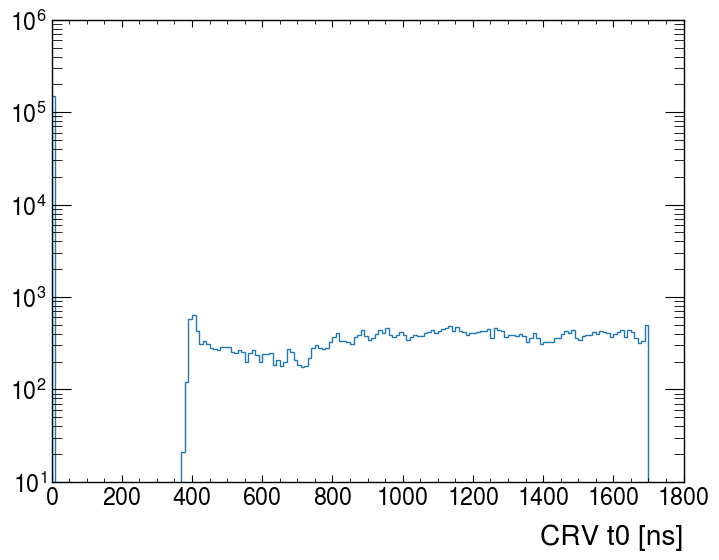

In [ ]:
plt.hist(dfCE.query(cut_current+" & " + cut_t0)['crvinfo_timeWindowStart'], bins=170, range=(0, 1700), histtype='step', label='After CRV cuts');
plt.xlabel('CRV t0 [ns]')
plt.yscale('log')

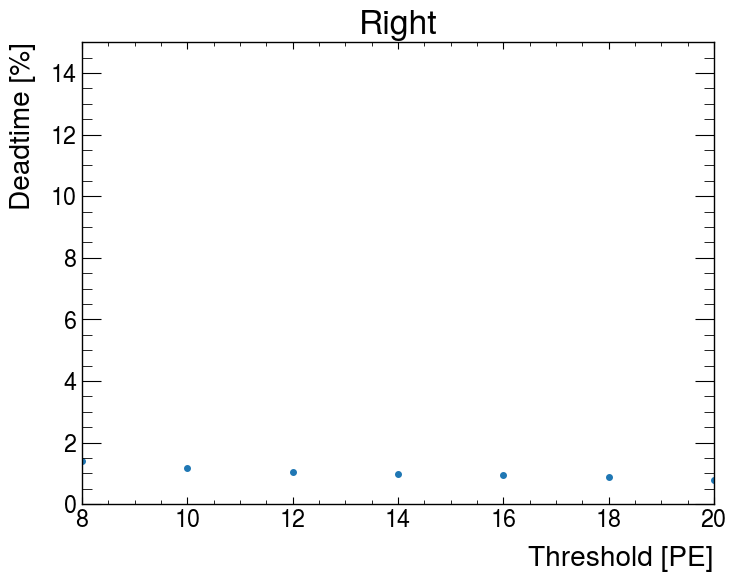

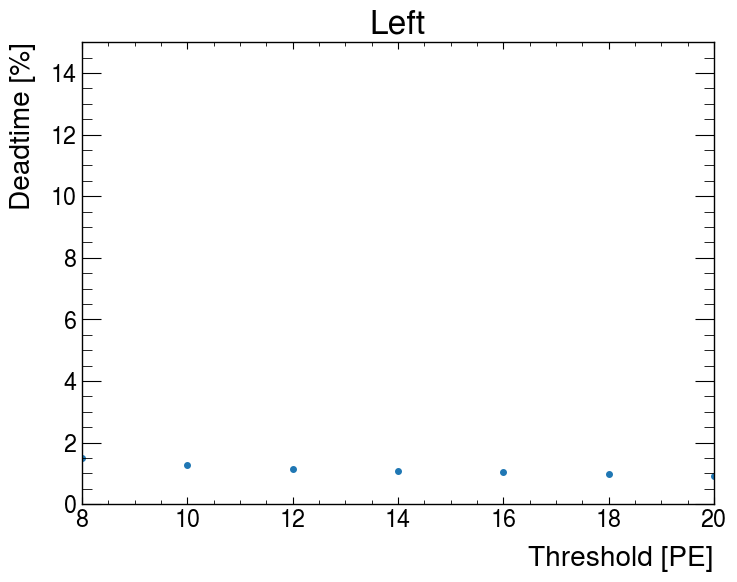

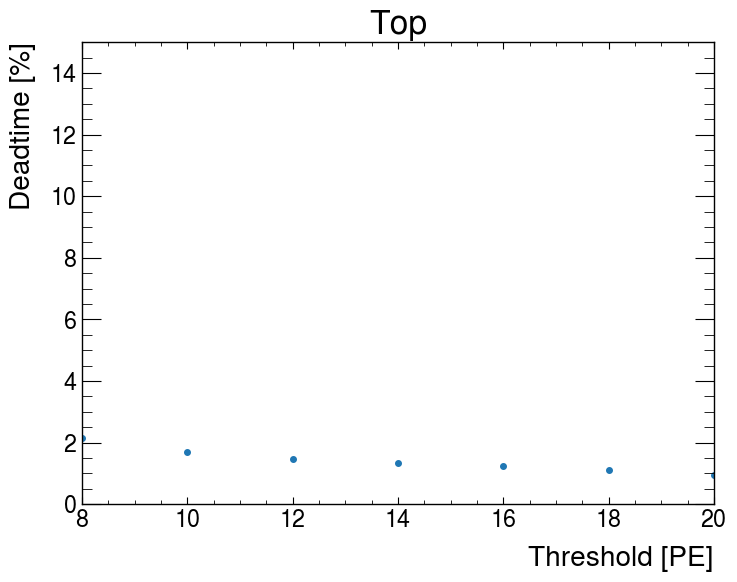

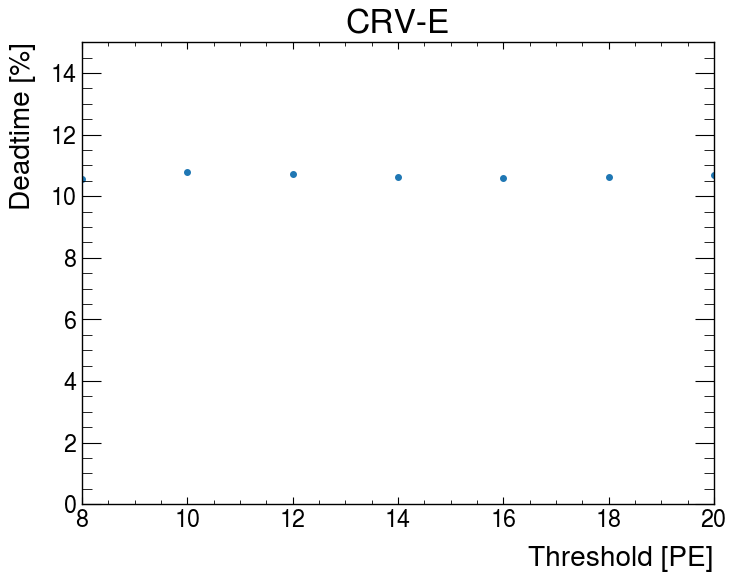

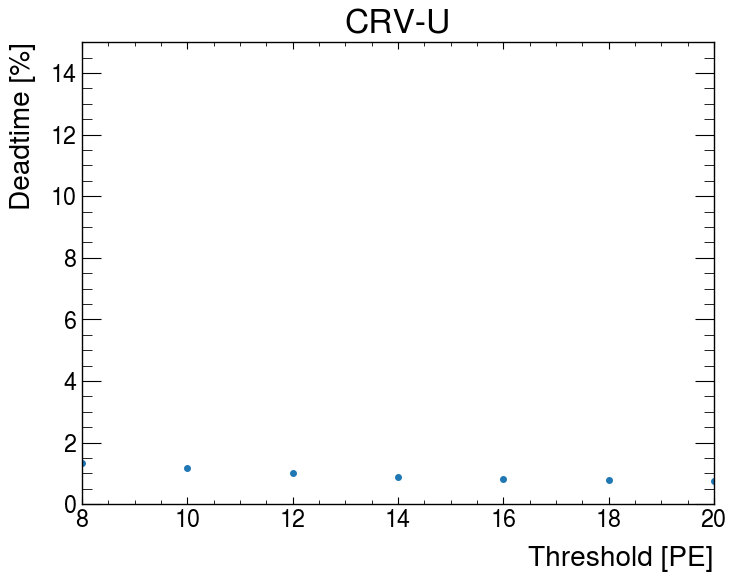

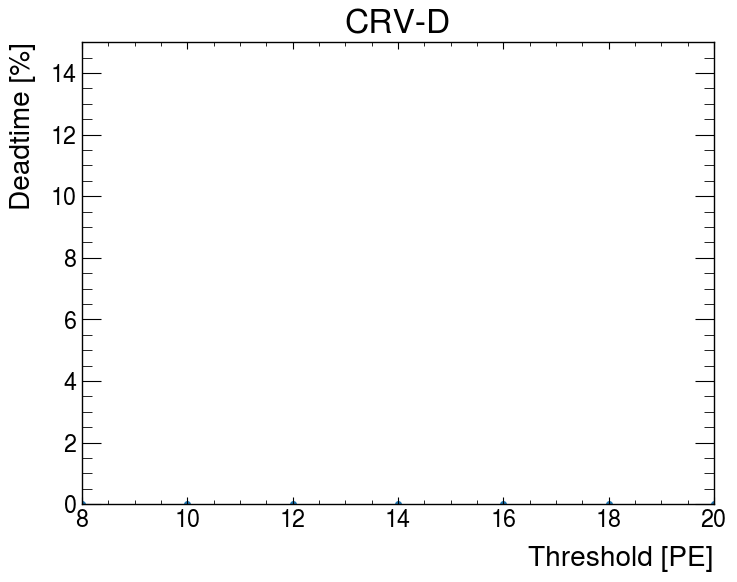

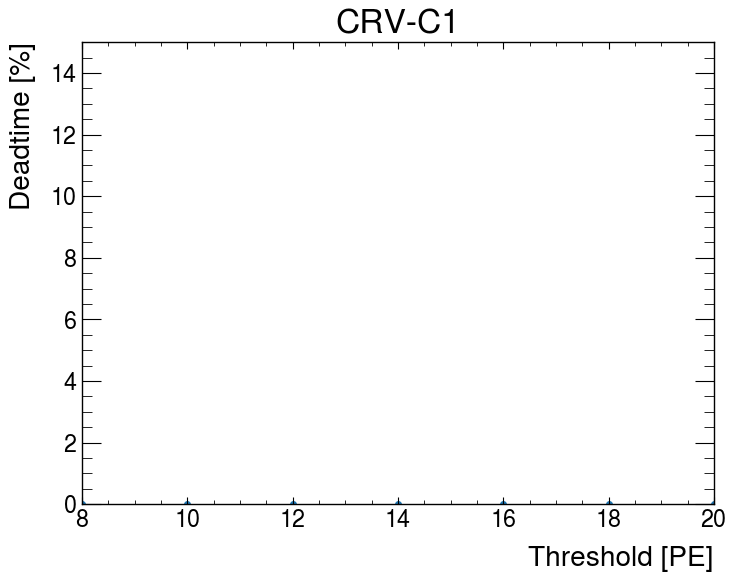

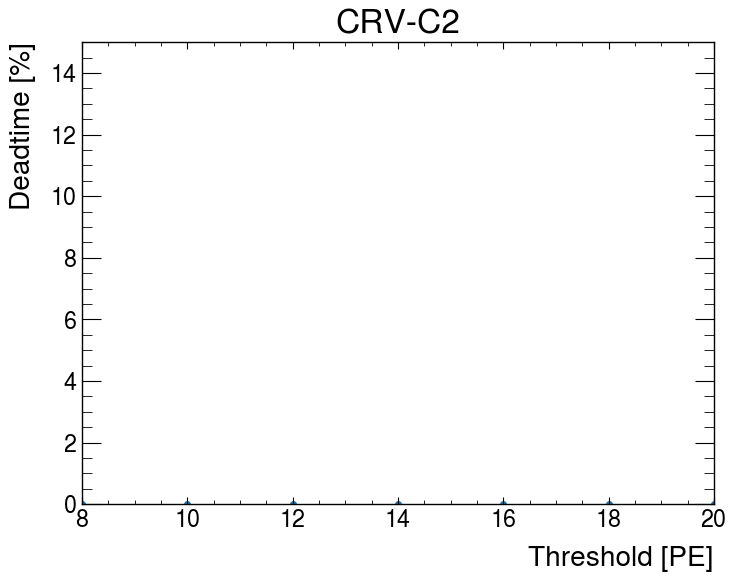

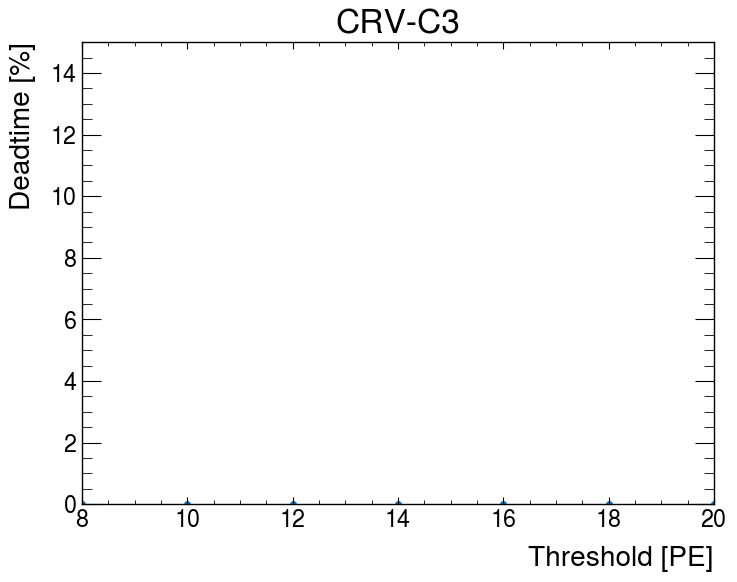

In [ ]:
th_list=[8,10,12,14,16,18,20]
def plot_deadtime(crvSector):
  dead_list=[]
  for th in th_list:
    crv_time_ = "(de_t0 > crv%dPEs_timeWindowStart + %d & de_t0 < crv%dPEs_timeWindowEnd + %d) & crv%dPEs_crvSectorType == %d" % (th, -TMAX, th,  -TMIN, th, crvSector)
    dead_time = len(dfCE.query(cut_extmom+"&"+crv_time_)) / len(dfCE.query(cut_extmom))
    dead_list.append(dead_time*100)

  plt.figure()
  plt.plot(th_list, dead_list, '.')
  plt.title(crvSector_list[sector])
  plt.ylabel("Deadtime [%]")
  plt.xlabel("Threshold [PE]")
  plt.ylim(0,15)
for sector in range(1,10):
    plot_deadtime(sector)


In [ ]:
list(dfCE)


['evtinfo_eventid',
 'evtinfo_runid',
 'evtinfo_subrunid',
 'evtinfo_nprotons',
 'evtinfo_pbtime',
 'evtinfo_pbterr',
 'evtinfomc_nprotons',
 'evtinfomc_pbtime',
 'de_status',
 'de_goodfit',
 'de_seedalg',
 'de_fitalg',
 'de_pdg',
 'de_nhits',
 'de_ndof',
 'de_nactive',
 'de_ndouble',
 'de_ndactive',
 'de_nplanes',
 'de_planespan',
 'de_nnullambig',
 'de_nmat',
 'de_nmatactive',
 'de_nseg',
 'de_t0',
 'de_t0err',
 'de_chisq',
 'de_fitcon',
 'de_radlen',
 'de_firsthit',
 'de_lasthit',
 'de_maxgap',
 'de_avggap',
 'deent_momX',
 'deent_momY',
 'deent_momZ',
 'deent_posX',
 'deent_posY',
 'deent_posZ',
 'deent_momerr',
 'deent_d0',
 'deent_maxr',
 'deent_td',
 'deent_Rad',
 'deent_Lambda',
 'deent_Cx',
 'deent_Cy',
 'deent_phi0',
 'deent_t0',
 'detrkpid_DeltaE',
 'detrkpid_ClusterLength',
 'detrkpid_RPOCA',
 'detrkpid_TrackDirection',
 'detrkpid_DeltaT',
 'detrkpid_mvaout',
 'detrkpid_mvastat',
 'detrkpid_disk0frad',
 'detrkpid_disk1frad',
 'detrkpid_disk0brad',
 'detrkpid_disk1brad',
 'c

In [ ]:
cut_current

'(de_status > 0) & (deent_td > 0.577350) & (deent_td < 1.000) & (deent_d0 > -80) & (deent_d0 < 105) & (deent_maxr > 450) & (deent_maxr < 680) & (dequal_TrkQual > 0.8) & (dequal_TrkPID > 0.95) & (ue_status <= 0) & (deent_mom > 90.000000) & (deent_mom < 140.000000) & (de_t0 > 650) & (de_t0 < 1625) & (((de_t0 < crv8PEs_timeWindowStart + -40) | (de_t0 > crv8PEs_timeWindowEnd + 150)) & crv8PEs_crvSectorType == 1) | (((de_t0 < crv8PEs_timeWindowStart + -30) | (de_t0 > crv8PEs_timeWindowEnd + 130)) & crv8PEs_crvSectorType == 2) | (((de_t0 < crv8PEs_timeWindowStart + -40) | (de_t0 > crv8PEs_timeWindowEnd + 170)) & crv8PEs_crvSectorType == 3) | (((de_t0 < crv8PEs_timeWindowStart + 0) | (de_t0 > crv8PEs_timeWindowEnd + 70)) & crv8PEs_crvSectorType == 4) | (((de_t0 < crv8PEs_timeWindowStart + -20) | (de_t0 > crv8PEs_timeWindowEnd + 90)) & crv8PEs_crvSectorType == 5) | (((de_t0 < crv8PEs_timeWindowStart + -40) | (de_t0 > crv8PEs_timeWindowEnd + 200)) & crv8PEs_crvSectorType == 6) | (((de_t0 < crv8

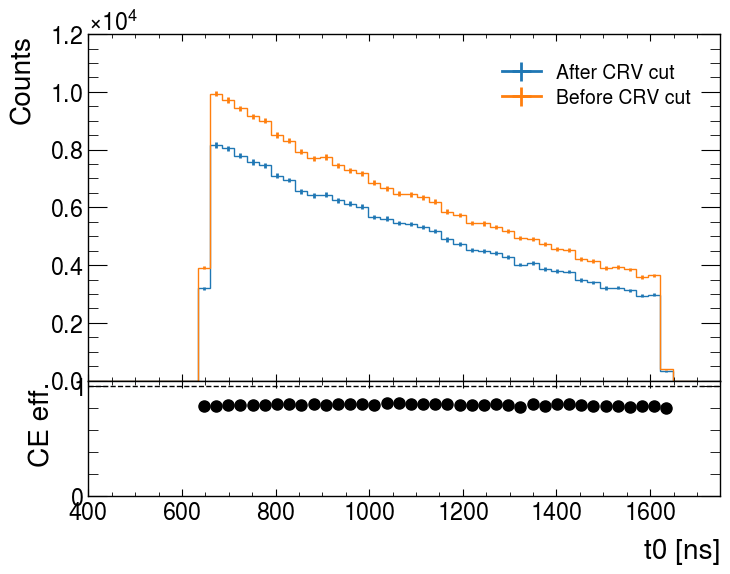

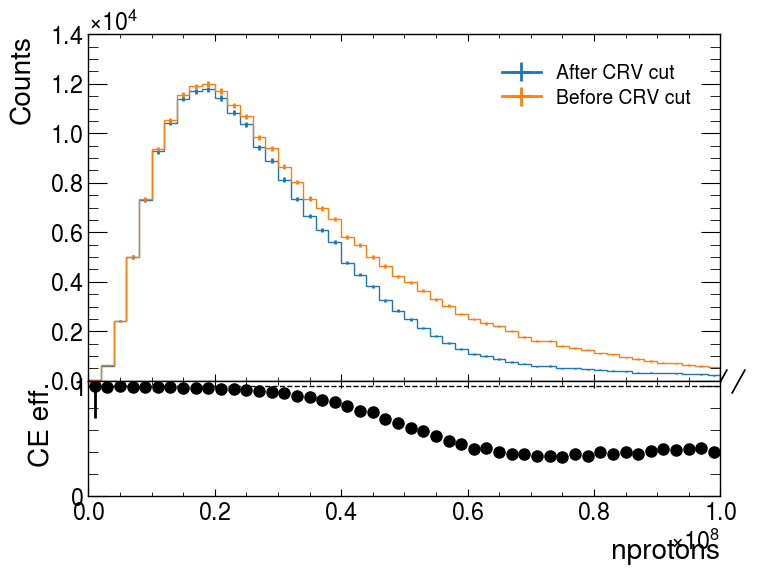

In [ ]:
cut_current = cut_extmom+" & "+crv_time
#cut_current = cut_extmom+" & "+crv_time_ext
#cut_current = crv_time_ext
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(50, 400, 1700, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
)

h.fill(cat="all", x=dfCE.query(cut_extmom)['de_t0'].to_numpy())
h.fill(cat="cut", x=dfCE.query(cut_current)['de_t0'].to_numpy());

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.0, 1.05], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('CE eff.')
fig.get_axes()[1].set_xlim(400,1750)

h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(50, 0, 1E8, name="x", label="nprotons"),
  hist.storage.Weight(),
)

h.fill(cat="all", x=dfCE.query(cut_extmom)['evtinfomc_nprotons'].to_numpy())
h.fill(cat="cut", x=dfCE.query(cut_current)['evtinfomc_nprotons'].to_numpy());

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.0, 1.05], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('CE eff.');

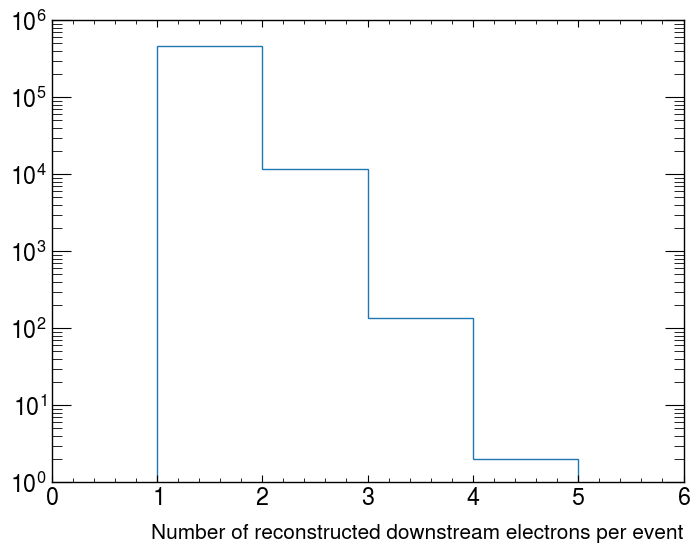

In [ ]:
plt.hist(dfCE.groupby(['evtinfo_subrunid',	'evtinfo_eventid', 'evtinfomc_nprotons']).size().reset_index()[0], histtype='step', bins=6, range=(0,6));
plt.xlabel('Number of reconstructed downstream electrons per event', fontsize=15)
plt.yscale('log')